<center><h1><b>Импорт библиотек и загрузка данных</b></h1></center>

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from lightgbm import Dataset, LGBMRegressor, cv, early_stopping, plot_tree
from matplotlib.ticker import NullLocator
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error, r2_score
    )
from sklearn.model_selection import (
    GridSearchCV, TimeSeriesSplit,
    cross_val_score, train_test_split
    )
from statsmodels.tsa.stattools import adfuller

In [107]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [108]:
path: str = "Dataset1.xlsx"
df: pd.DataFrame = pd.read_excel(path)
df.index = df["Дата и время"].dt.round("H")
df.drop(columns=["Дата и время"], inplace=True)
df

Электропотребление
Дата и время                           
2019-01-01 00:00:00             215.191
2019-01-01 01:00:00             202.239
2019-01-01 02:00:00             188.462
2019-01-01 03:00:00             179.276
2019-01-01 04:00:00             173.035
...                                 ...
2023-06-29 19:00:00             176.542
2023-06-29 20:00:00             188.429
2023-06-29 21:00:00             183.351
2023-06-29 22:00:00             170.048
2023-06-29 23:00:00             152.483

[39384 rows x 1 columns]

<center><h1><b>Разведочный анализ данных</b></h1></center>

In [109]:
df["Электропотребление"].describe()

count    39384.000000
mean       184.463841
std         43.164006
min         93.956000
25%        156.352000
50%        179.881500
75%        213.911500
max        321.055000
Name: Электропотребление, dtype: float64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39384 entries, 0 to 39383
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Дата и время        39384 non-null  datetime64[ns]
 1   Электропотребление  39384 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 615.5 KB


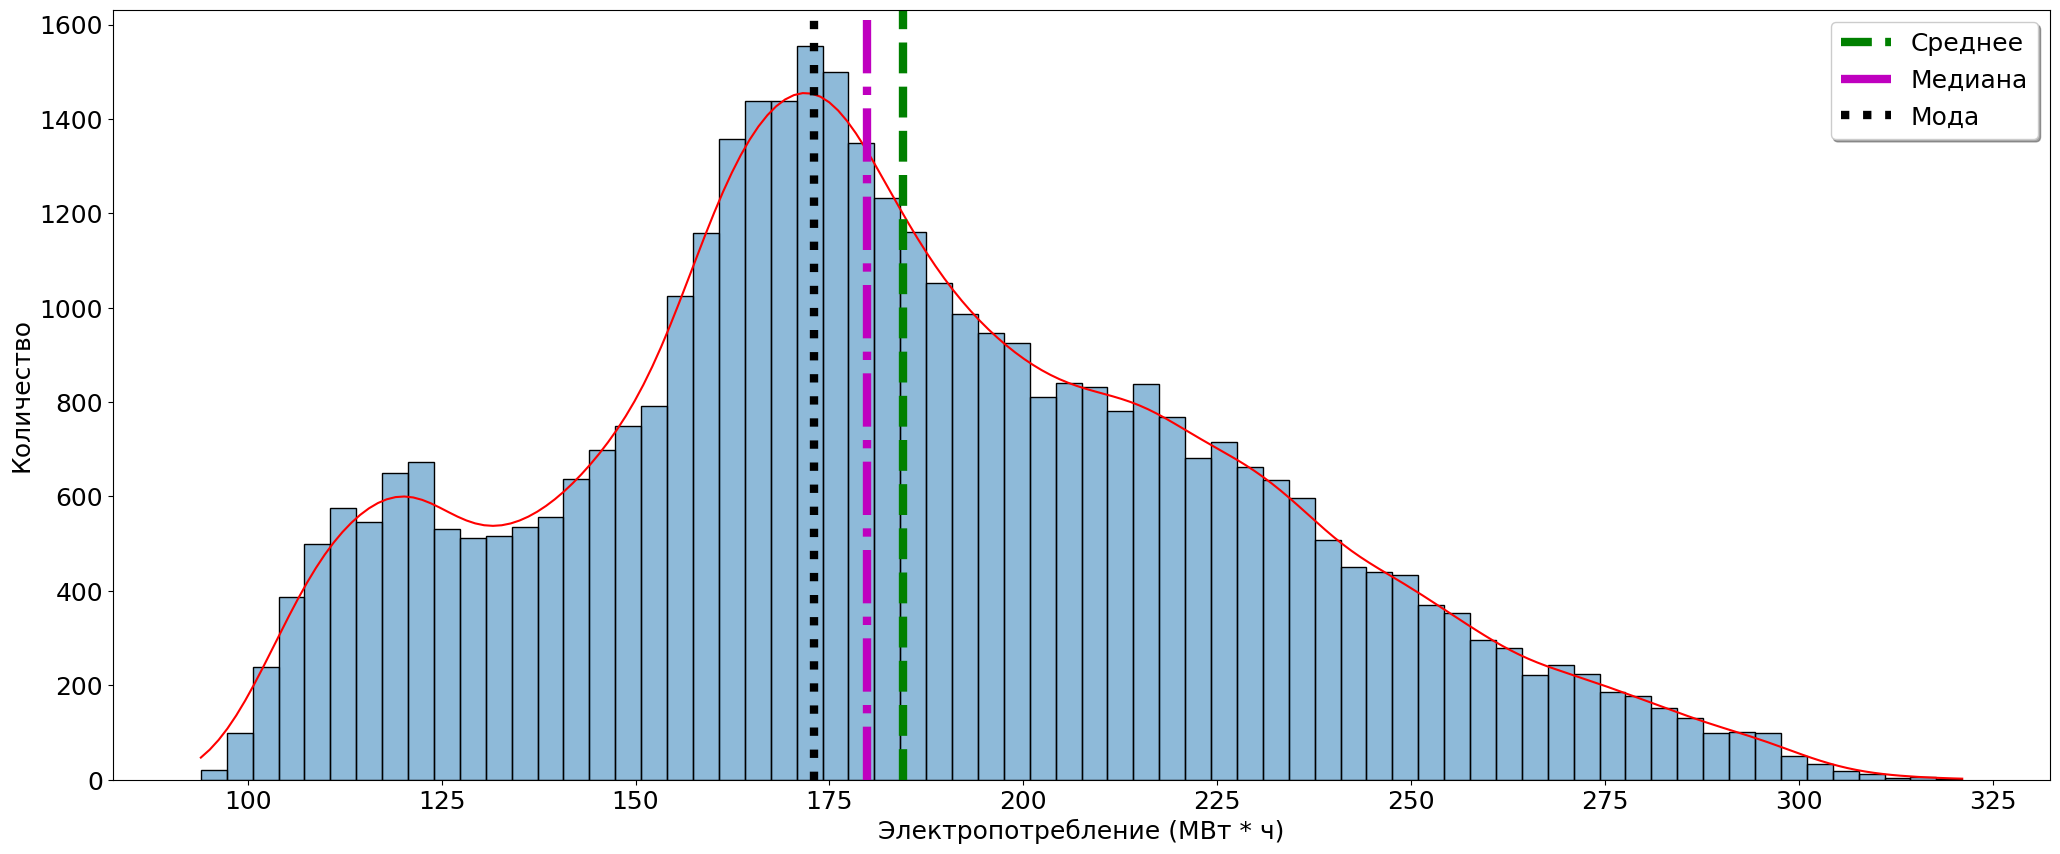

In [75]:
plt.figure(figsize=(25, 10))
ax = sns.histplot(df["Электропотребление"], kde=True)
ax.lines[0].set_color("red")
plt.axvline(
    x=df["Электропотребление"].mean(),
    linewidth=6,
    linestyle="--",
    color="g",
    label="Среднее"
)
plt.axvline(
    x=df["Электропотребление"].median(),
    linewidth=6,
    linestyle="-.",
    color="m",
    label="Медиана"
)
plt.axvline(x=173, linewidth=6, linestyle=":", color="k", label="Мода")
plt.xlabel("Электропотребление (МВт * ч)", fontsize=18)
plt.xticks(np.arange(100, 350, 25), fontsize=18)
plt.ylabel("Количество", fontsize=18)
plt.yticks(np.arange(0, 1800, 200), fontsize=18)
plt.legend(loc="best", fontsize=18, shadow=True)
plt.show()

<h2>
    График не симметричен относительно выборочного среднего.<br>
    Выборочное среднее, мода и медиана не равны. <br>
    Ярко выражен длинный "правый хвост".
</h2>

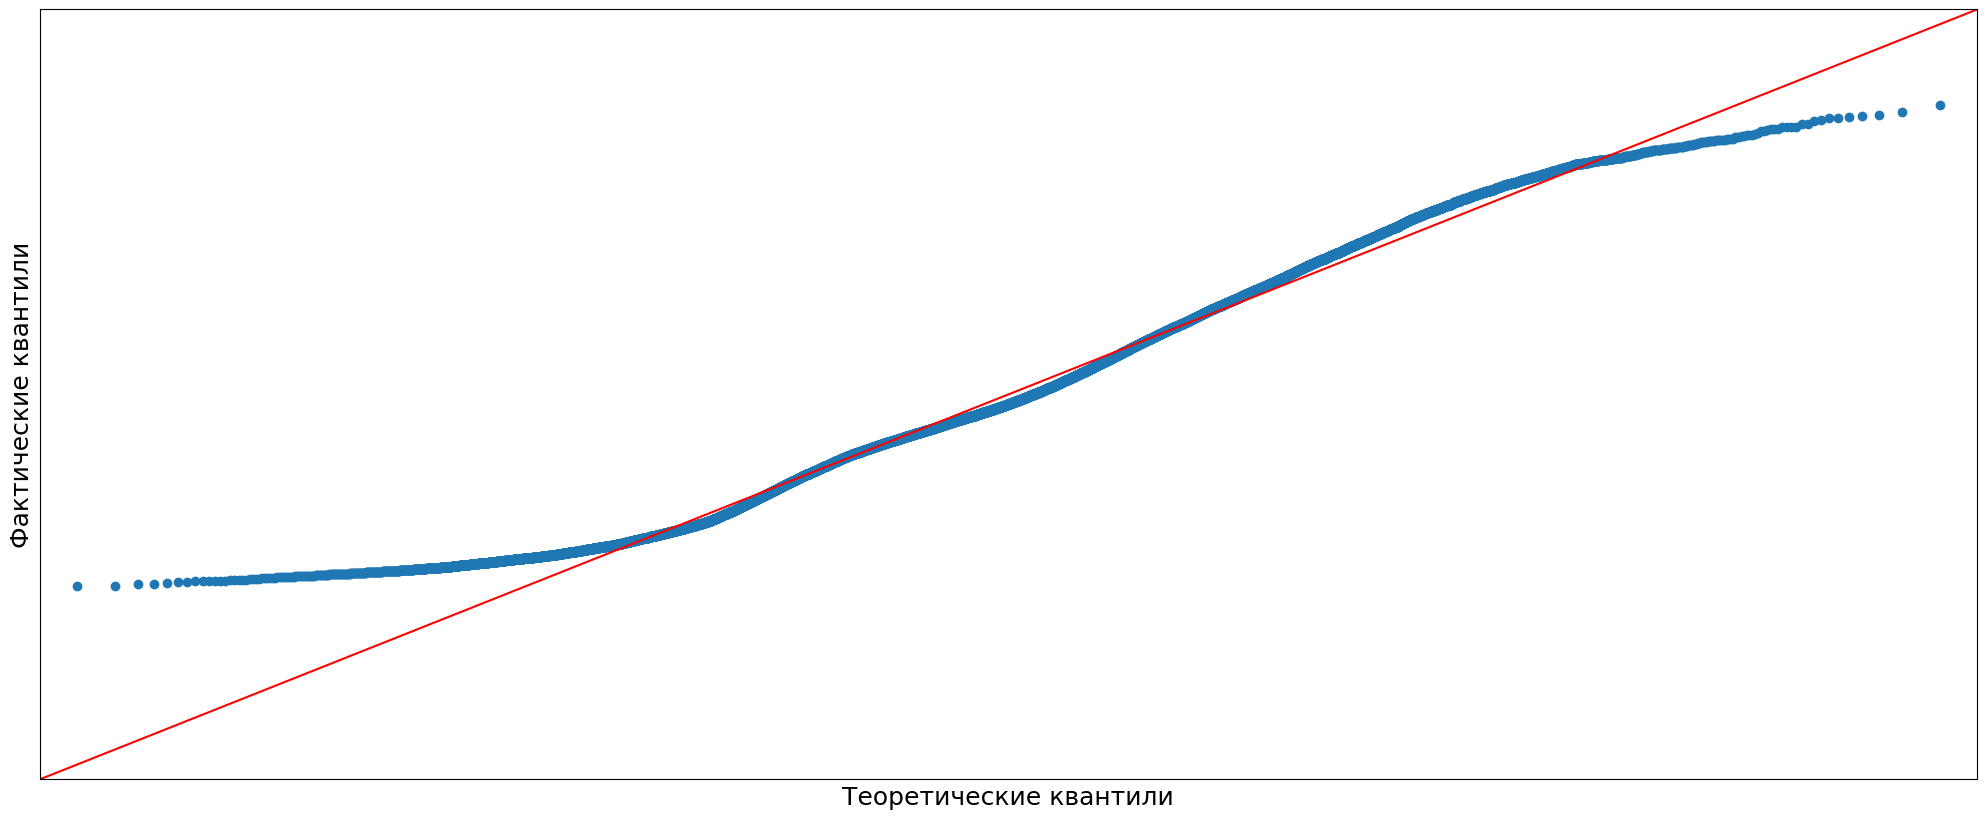

In [7]:
fig, ax = plt.subplots(figsize=(25, 10))
sm.qqplot(df["Электропотребление"], line="45", fit=True, ax=ax)
ax.yaxis.set_major_locator(NullLocator())
ax.xaxis.set_major_locator(NullLocator())
plt.xlabel("Теоретические квантили", fontsize=18)
plt.ylabel("Фактические квантили", fontsize=18)
plt.show()

<h2>
    Распределение отлично от нормального.<br>
    Гипотеза о нормальности распределения на больших выборках почти всегда отклоняется.<br>
    Функция scipy.stats.shapiro пишет, что при выборке больше 5000 результат оценки может быть неточным.
</h2>

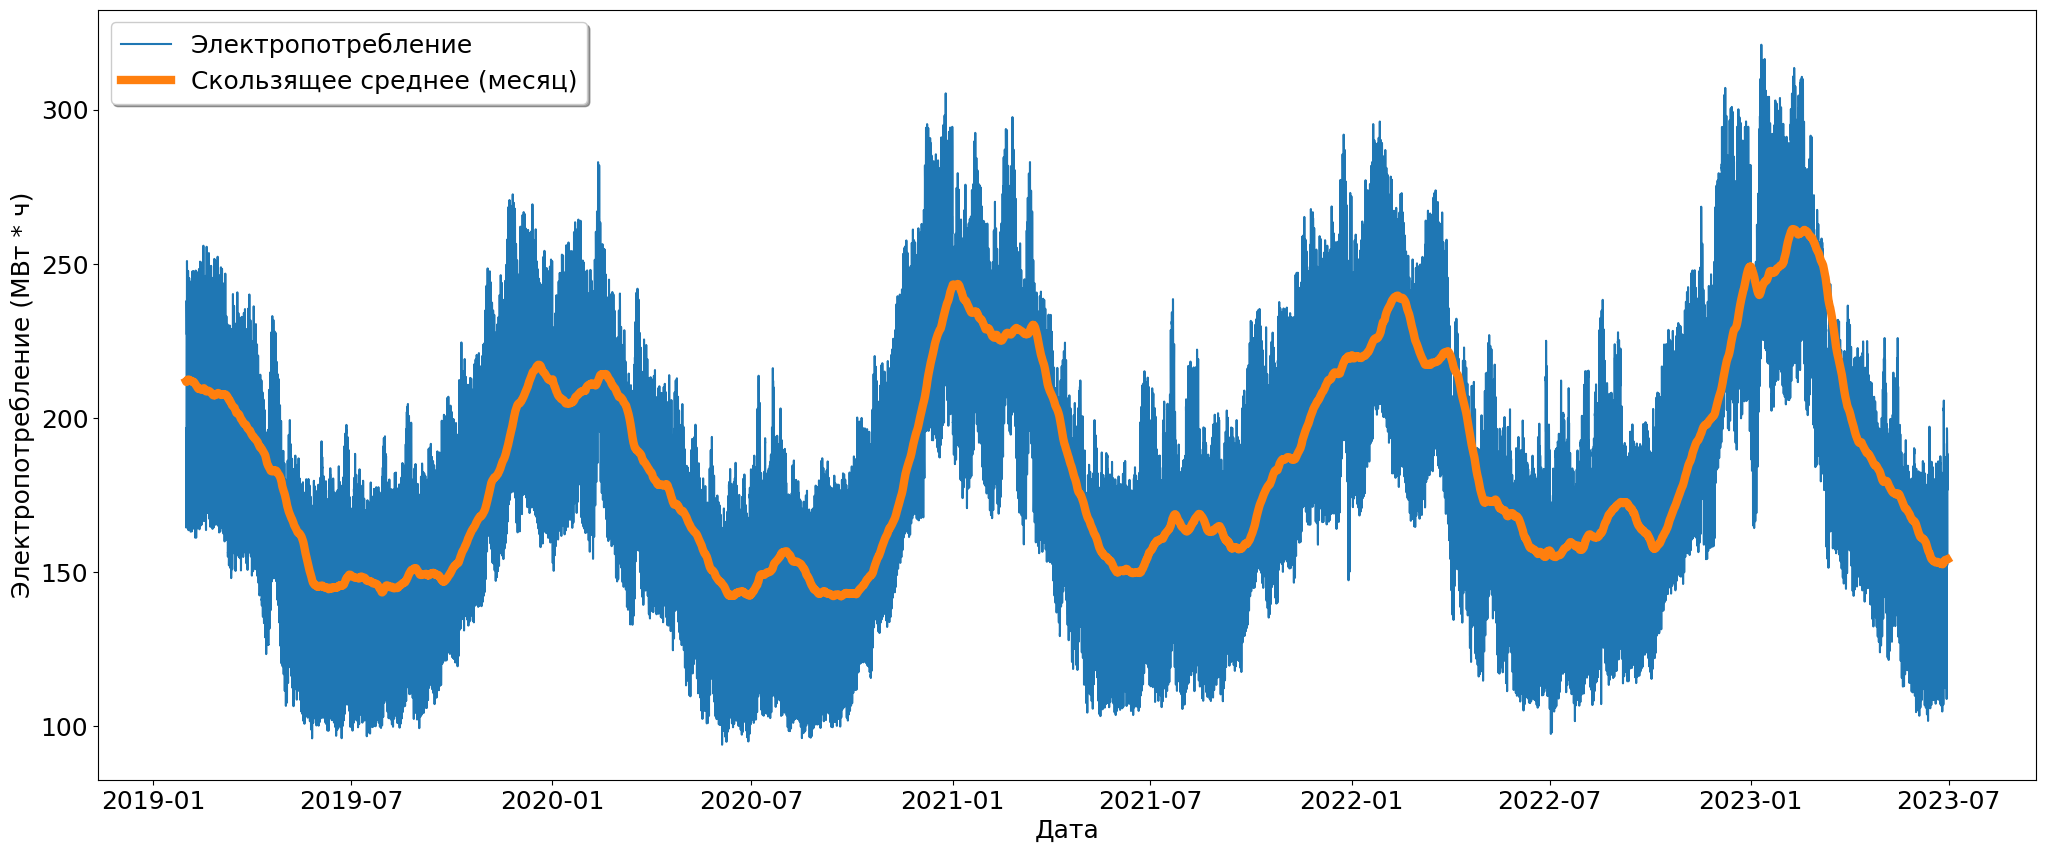

In [84]:
window_size: int = 24 * 30
moving_average: pd.Series = df["Электропотребление"].rolling(window_size).mean()
plt.figure(figsize=(25, 10))
plt.plot(
    df["Электропотребление"][window_size - 1 :],
    label="Электропотребление"
)
plt.plot(
    moving_average[window_size - 1 :],
    label="Скользящее среднее (месяц)",
    linewidth=6
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(100, 350, 50), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

<h2>В ряде отсутствует ярко выраженный тренд.</h2>

In [9]:
p_value_c: float = adfuller(df["Электропотребление"], regression="c")[1]
p_value_ct: float = adfuller(df["Электропотребление"], regression="ct")[1]
p_value_ctt: float = adfuller(df["Электропотребление"], regression="ctt")[1]
alpha: float = 0.05 / 3  # уровень значимости вместе с поправкой Бонферрони
print(f"{p_value_c=:.3f} и {alpha=:.3f}")
print(f"{p_value_ct=:.3f} и {alpha=:.3f}")
print(f"{p_value_ctt=:.3f} и {alpha=:.3f}")

p_value_c=0.001 и alpha=0.017
p_value_ct=0.003 и alpha=0.017
p_value_ctt=0.013 и alpha=0.017


<h2>С 95-% вероятностью можно утверждать, что ряд является стационарным.</h2>

<center><h1><b>Выявление аномалий</b></h1></center>

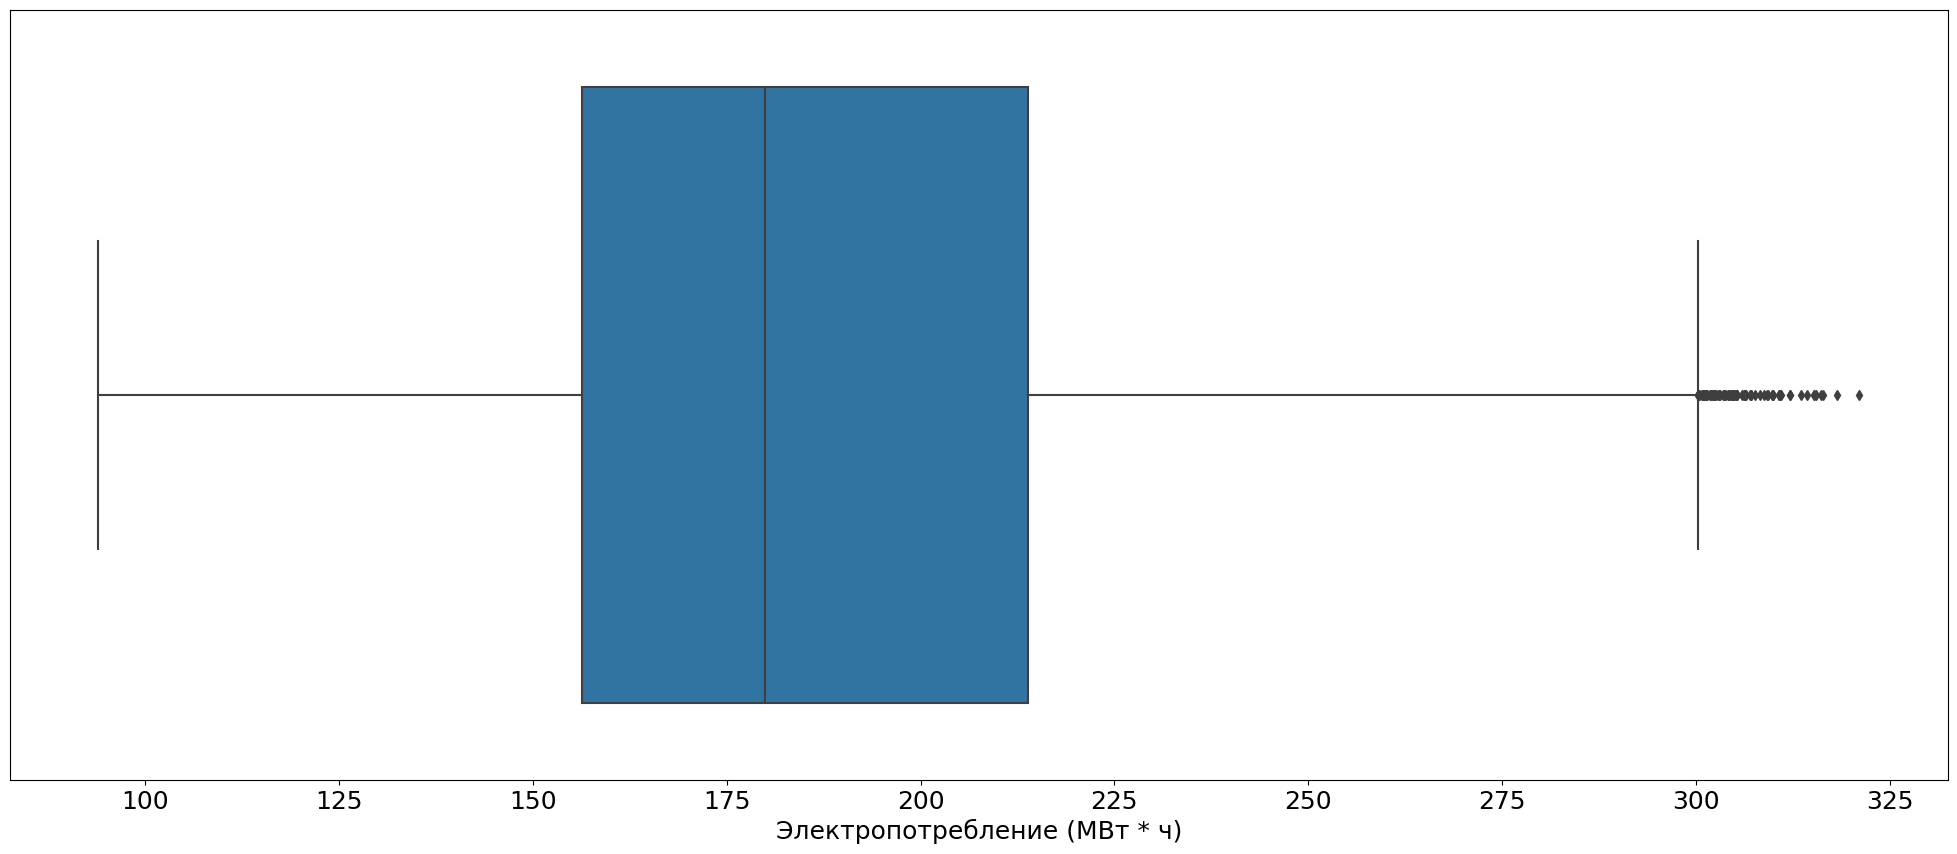

In [8]:
plt.figure(figsize=(25, 10))
ax1 = sns.boxplot(df["Электропотребление"], orient="h")
ax1.yaxis.set_major_locator(NullLocator())
plt.xlabel("Электропотребление (МВт * ч)", fontsize=18)
plt.xticks(np.arange(100, 350, 25), fontsize=18)
plt.show()

In [110]:
IQR: float = df["Электропотребление"].quantile(q=0.75) - df["Электропотребление"].quantile(
    q=0.25
)
right_hence: float = df["Электропотребление"].quantile(q=0.75) + IQR * 1.5
print(f"Верхний порог равен {right_hence:.3f}")

Верхний порог равен 300.251


In [111]:
df_outliers: pd.DataFrame = df.query("Электропотребление > @right_hence")
df_outliers

Электропотребление
Дата и время                           
2020-12-25 17:00:00             305.278
2020-12-25 18:00:00             300.871
2022-12-07 17:00:00             304.700
2022-12-08 16:00:00             301.042
2022-12-08 17:00:00             307.041
...                                 ...
2023-02-17 10:00:00             302.484
2023-02-17 11:00:00             303.531
2023-02-17 18:00:00             309.860
2023-02-17 19:00:00             306.978
2023-02-17 20:00:00             300.256

[86 rows x 1 columns]

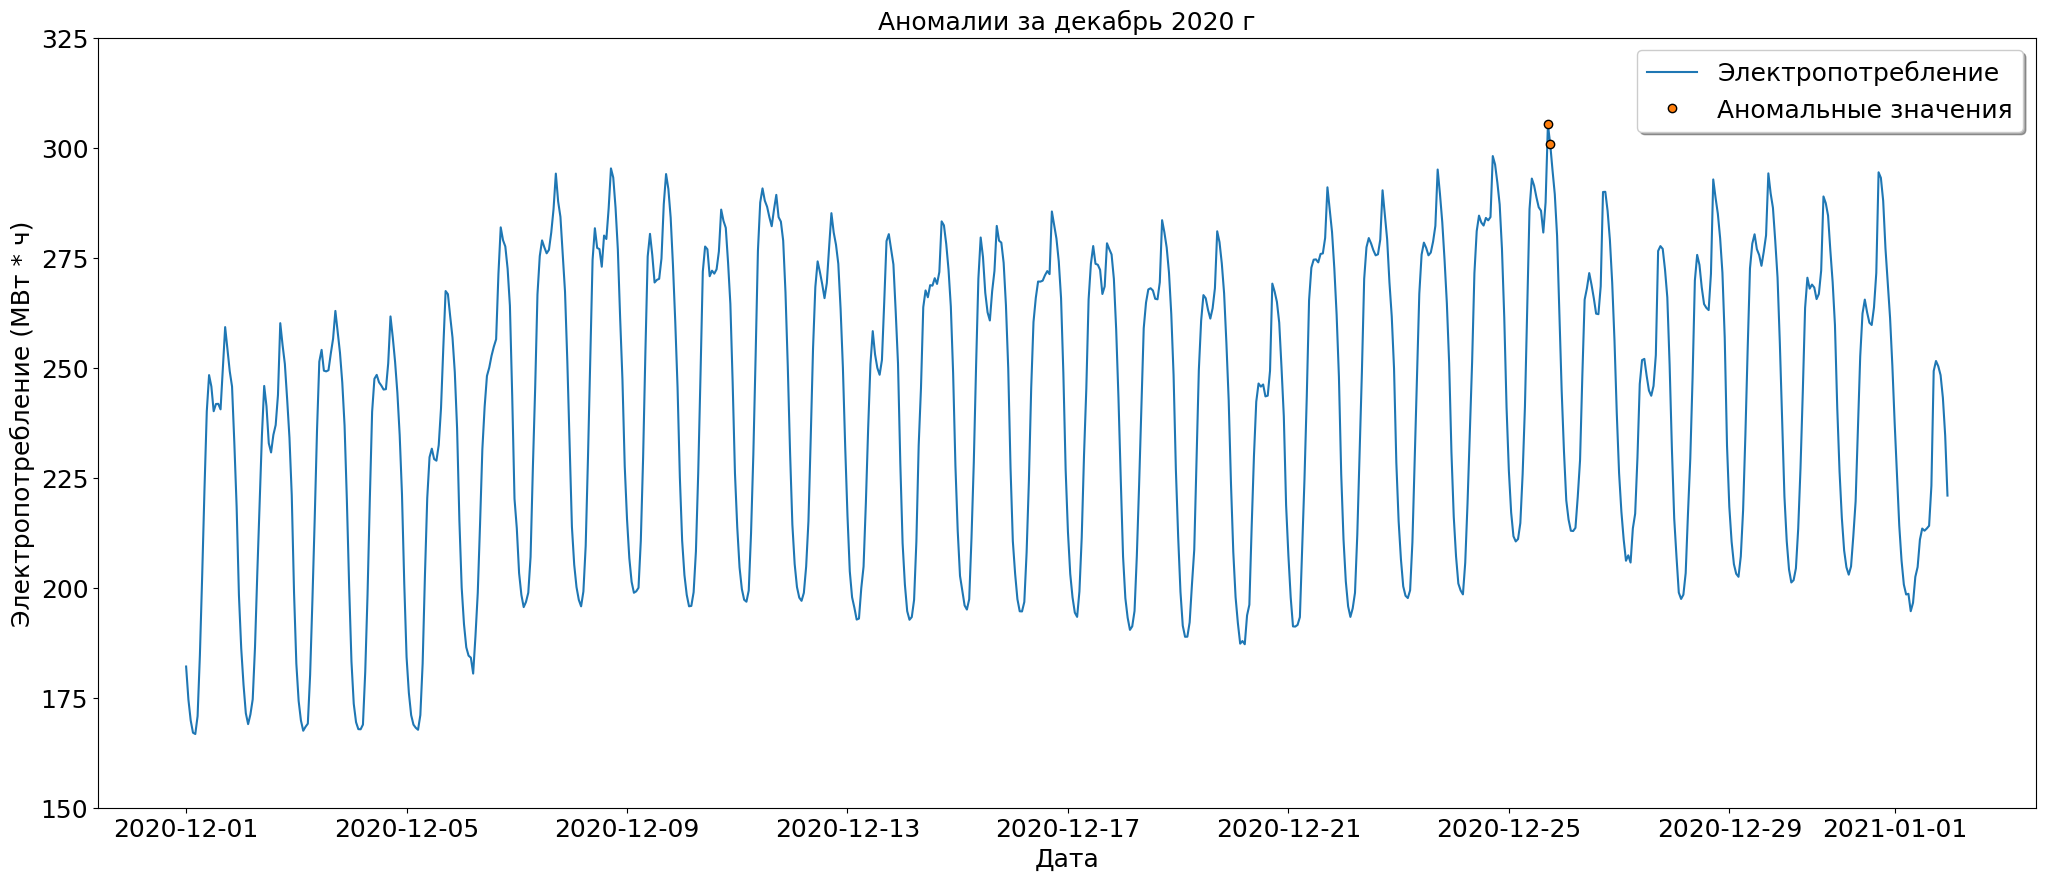

In [98]:
plt.figure(figsize=(25, 10))
plt.title("Аномалии за декабрь 2020 г", fontsize=18)
plt.plot(
    df["Электропотребление"].loc["2020-12-01":"2021-01-01"],
    label="Электропотребление"
)
plt.plot(
    df_outliers["Электропотребление"].loc["2020-12-01":"2021-01-01"],
    label="Аномальные значения",
    marker="o",
    markeredgecolor="k",
    linestyle=""
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

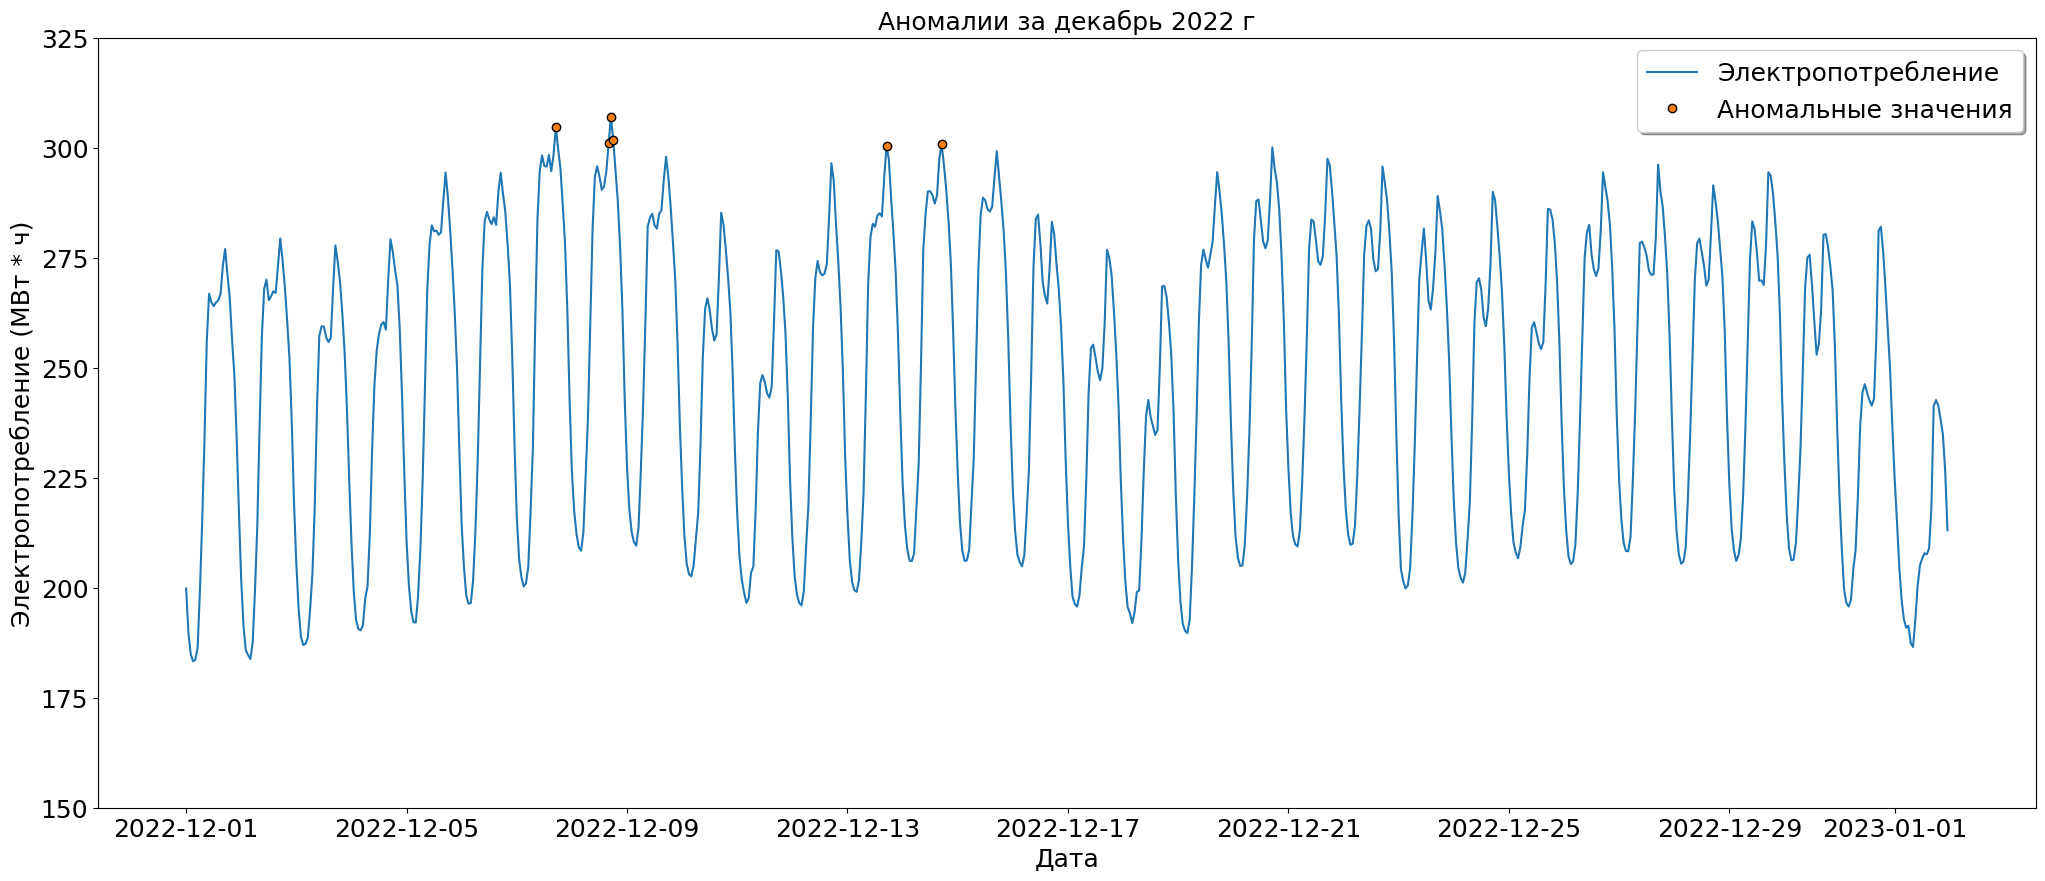

In [99]:
plt.figure(figsize=(25, 10))
plt.title("Аномалии за декабрь 2022 г", fontsize=18)
plt.plot(
    df["Электропотребление"].loc["2022-12-01":"2023-01-01"],
    label="Электропотребление"
)
plt.plot(
    df_outliers["Электропотребление"].loc["2022-12-01":"2023-01-01"],
    label="Аномальные значения",
    marker="o",
    markeredgecolor="k",
    linestyle=""
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

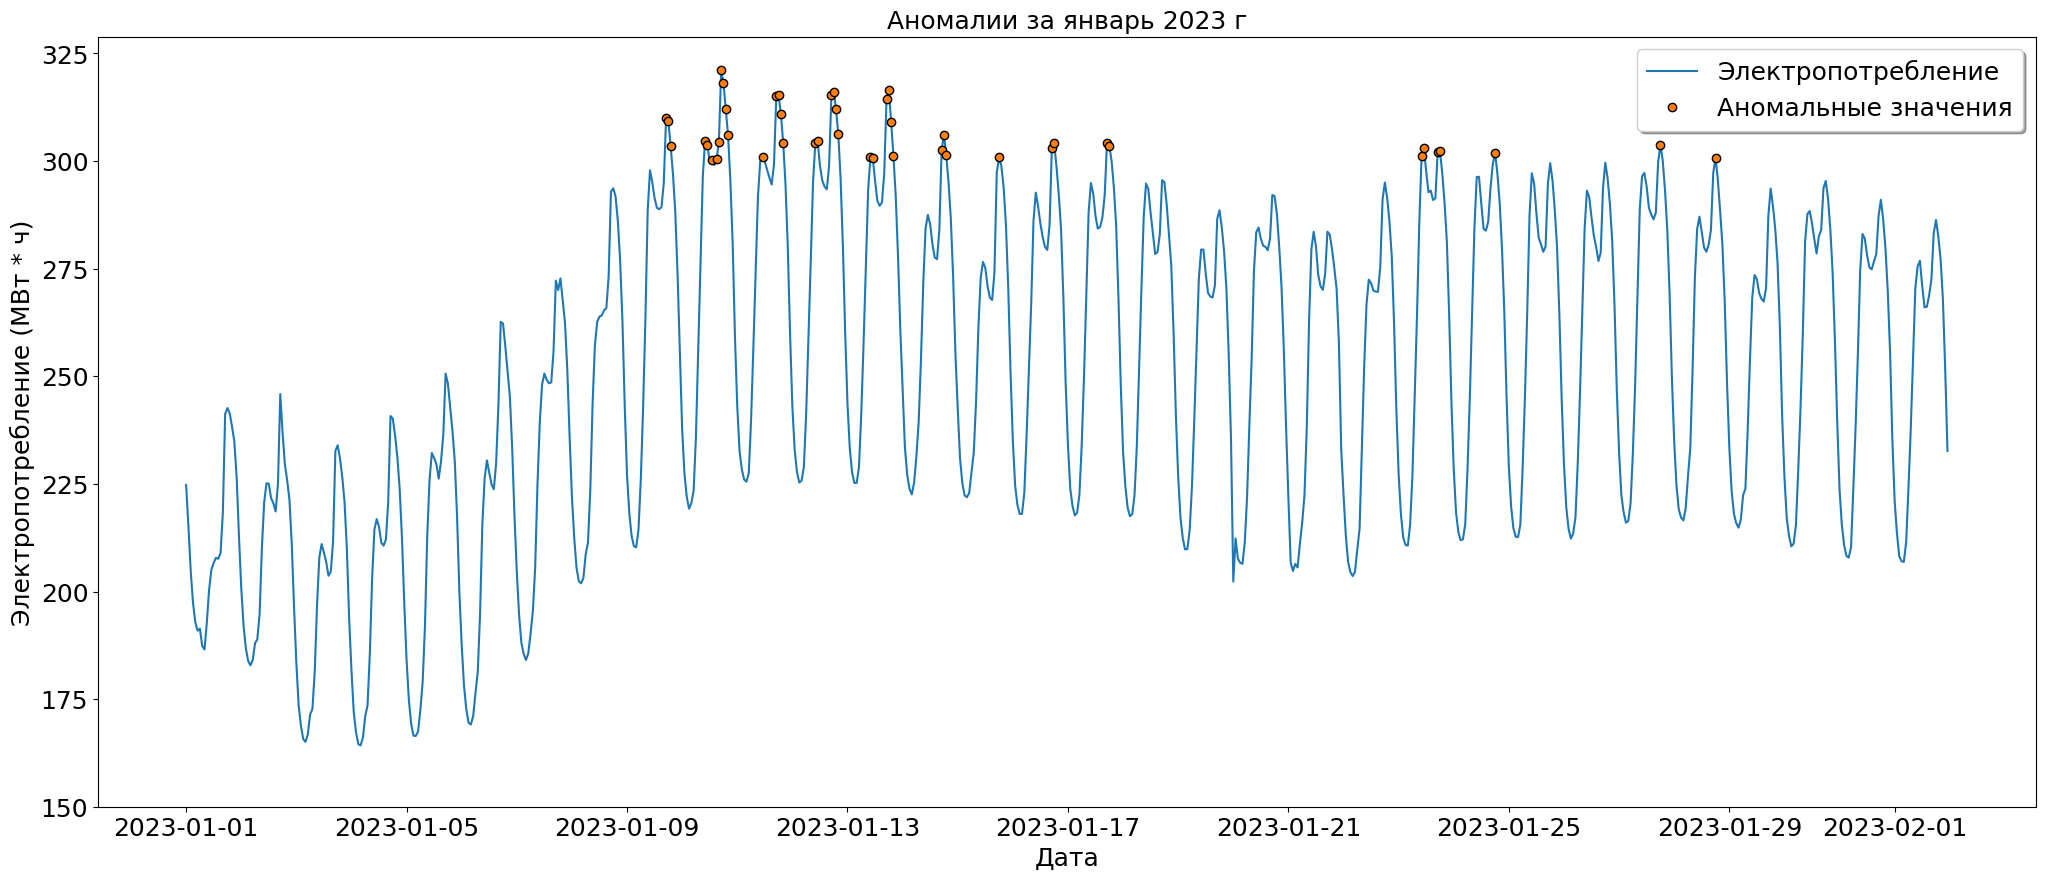

In [100]:
plt.figure(figsize=(25, 10))
plt.title("Аномалии за январь 2023 г", fontsize=18)
plt.plot(
    df["Электропотребление"].loc["2023-01-01":"2023-02-01"],
    label="Электропотребление"
)
plt.plot(
    df_outliers["Электропотребление"].loc["2023-01-01":"2023-02-01"],
    label="Аномальные значения",
    marker="o",
    markeredgecolor="k",
    linestyle=""
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

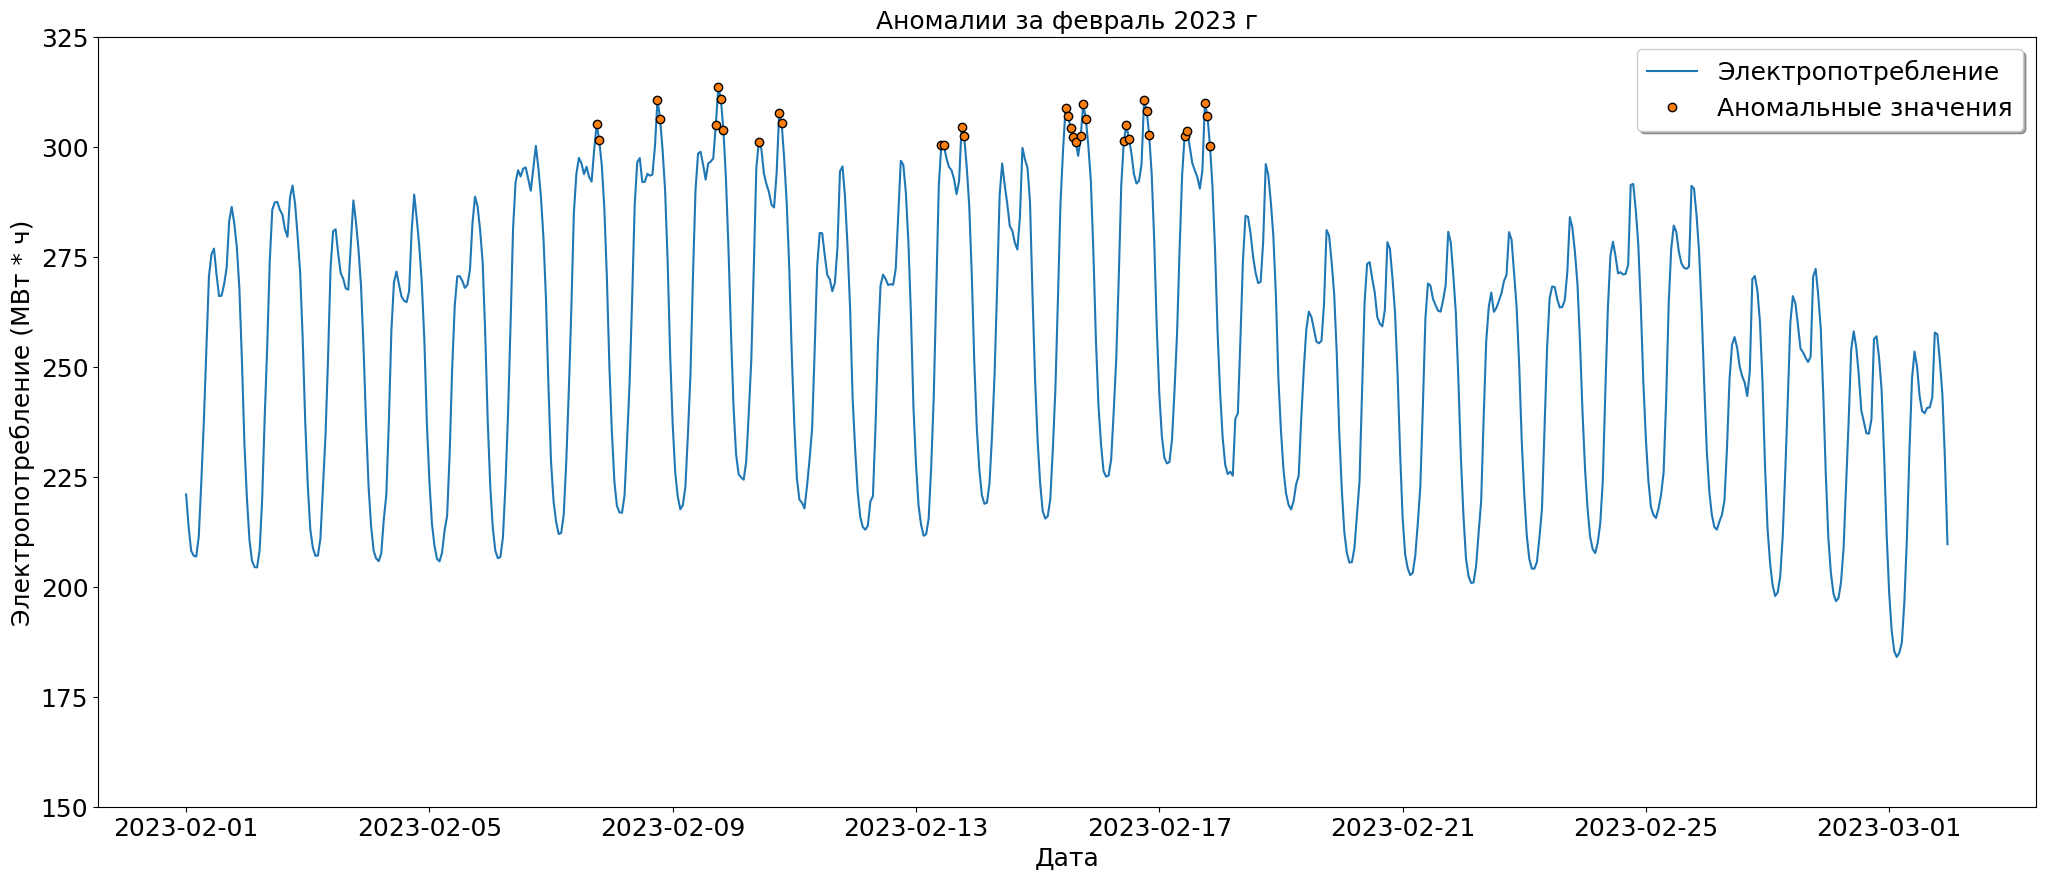

In [101]:
plt.figure(figsize=(25, 10))
plt.title("Аномалии за февраль 2023 г", fontsize=18)
plt.plot(
    df["Электропотребление"].loc["2023-02-01":"2023-03-01"],
    label="Электропотребление"
)
plt.plot(
    df_outliers["Электропотребление"].loc["2023-02-01":"2023-03-01"],
    label="Аномальные значения",
    marker="o",
    markeredgecolor="k",
    linestyle=""
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

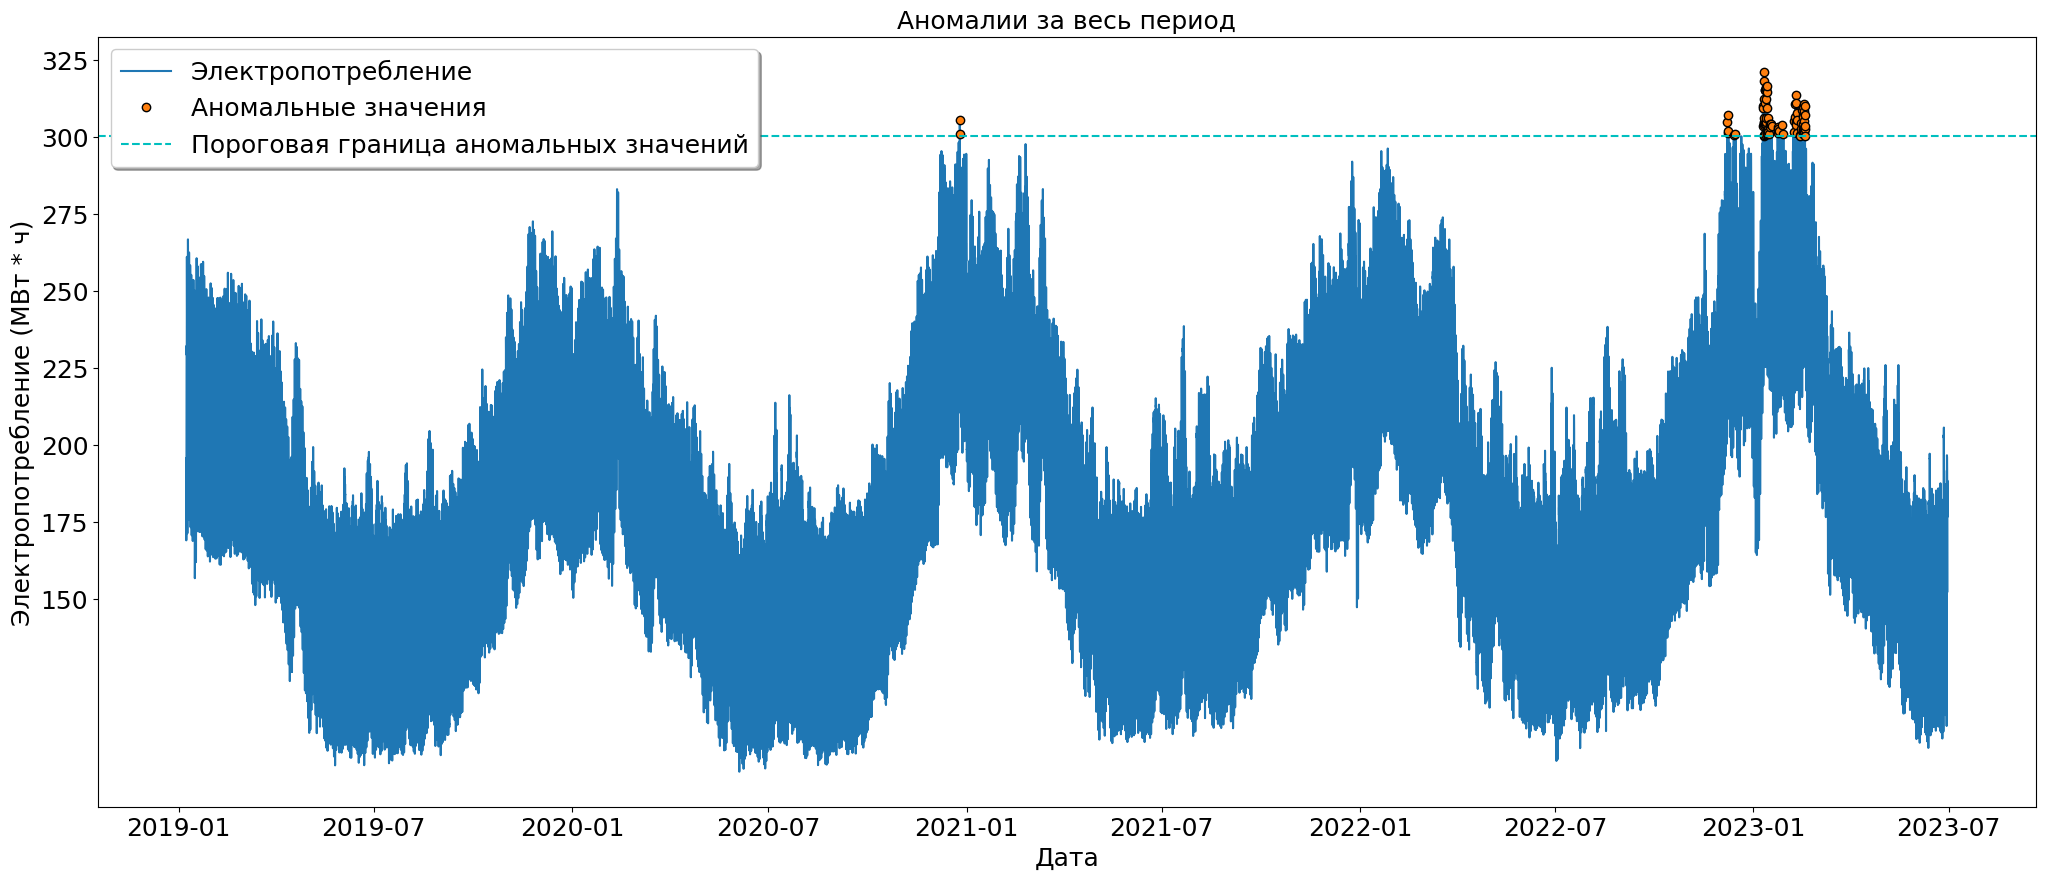

In [104]:
plt.figure(figsize=(25, 10))
plt.title("Аномалии за весь период", fontsize=18)
plt.plot(
    df["Электропотребление"],
    label="Электропотребление"
)
plt.plot(
    df_outliers["Электропотребление"],
    label="Аномальные значения",
    marker="o",
    markeredgecolor="k",
    linestyle=""
)
plt.axhline(
    right_hence,
    label="Пороговая граница аномальных значений",
    linestyle="--",
    color="c"
)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(np.arange(150, 350, 25), fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="best", shadow=True, fontsize=18)
plt.show()

In [112]:
outlier_count: pd.DataFrame = df_outliers["Электропотребление"].count()
outlier_count

86

In [113]:
round(outlier_count / len(df) * 100, 3)

0.218

<h2>0.218 % аномальных значений и все они приходятся на зимний период.</h2>

<center>
    <h1><b>Конструирование признаков</b></h1>
</center>

In [114]:
def create_times_of_day(data: pd.DataFrame) -> pd.Series:
    """Создает столбец период времени суток.
    Строки группируются по часам.

    - 0 (ночь) [0 - 5]
    - 1 (утро) [6 - 11]
    - 2 (обед) [12 - 17]
    - 3 (вечер) [18 - 23]

    Parameters
    ----------
    data : pandas.DataFrame
        Входные данные.

    Returns
    ----------
    `~pandas.Series`
    """
    day_periods = pd.cut(data.index.hour, bins=4, labels=range(4))
    return day_periods

In [116]:
def add_time_features(data: pd.DataFrame) -> None:
    """Добавляет столбцы, связанные с датой.

    - Час [0 - 23]
    - Период времени суток [0 - 3]
    - День недели [0 - 6]
    - Выходной [0 - 1]
    - Месяц [1 - 12]
    - День в году [1 - 366]

    Parameters
    ----------
    data : pandas.DataFrame
        Входные данные.
    """
    data["Час"] = data.index.hour.astype("category")
    data["Период времени суток"] = create_times_of_day(data).astype("category")
    data["День недели"] = data.index.dayofweek.astype("category")
    data["Выходной"] = data["День недели"].isin([5, 6]).astype("int").astype("category")
    data["Месяц"] = data.index.month.astype("category")
    data["День в году"] = data.index.dayofyear

In [117]:
def add_lag_features(data: pd.DataFrame) -> None:
    """Добавляет столбцы, связанные с лагами целевой переменной.

    - Электропотребление лаг 1 день (смещение данных на 24 часа)
    - Электропотребление лаг 7 дней (смещение данных на 168 часов)

    Parameters
    ----------
    data : pandas.DataFrame
        Входные данные.
    """
    data["Электропотребление лаг 1 день"] = data["Электропотребление"].shift(24)
    data["Электропотребление лаг 7 дней"] = data["Электропотребление"].shift(24 * 7)

In [118]:
def preprocessing(data: pd.DataFrame) -> None:
    """Добавляет факторы связанные со временем и лаговые факторы, 
    удаляет строки с пропущенными значениями.
    """
    add_time_features(data)
    add_lag_features(data)
    data.dropna(inplace=True)

In [119]:
preprocessing(df)

In [120]:
df

Электропотребление Час Период времени суток День недели  \
Дата и время                                                                   
2019-01-08 00:00:00             195.697   0                    0           1   
2019-01-08 01:00:00             184.357   1                    0           1   
2019-01-08 02:00:00             174.130   2                    0           1   
2019-01-08 03:00:00             170.228   3                    0           1   
2019-01-08 04:00:00             169.023   4                    0           1   
...                                 ...  ..                  ...         ...   
2023-06-29 19:00:00             176.542  19                    3           3   
2023-06-29 20:00:00             188.429  20                    3           3   
2023-06-29 21:00:00             183.351  21                    3           3   
2023-06-29 22:00:00             170.048  22                    3           3   
2023-06-29 23:00:00             152.483  23                    3           3   

                    Выходной Месяц  День в году  \
Дата и время                                      
2019-01-08 00:00:00        0     1            8   
2019-01-08 01:00:00        0     1            8   
2019-01-08 02:00:00        0     1            8   
2019-01-08 03:00:00        0     1            8   
2019-01-08 04:00:00        0     1            8   
...                      ...   ...          ...   
2023-06-29 19:00:00        0     6          180   
2023-06-29 20:00:00        0     6          180   
2023-06-29 21:00:00        0     6          180   
2023-06-29 22:00:00        0     6          180   
2023-06-29 23:00:00        0     6          180   

                     Электропотребление лаг 1 день  \
Дата и время                                         
2019-01-08 00:00:00                        191.298   
2019-01-08 01:00:00                        179.960   
2019-01-08 02:00:00                        172.706   
2019-01-08 03:00:00                        169.160   
2019-01-08 04:00:00                        167.794   
...                                            ...   
2023-06-29 19:00:00                        171.040   
2023-06-29 20:00:00                        183.232   
2023-06-29 21:00:00                        177.985   
2023-06-29 22:00:00                        164.705   
2023-06-29 23:00:00                        148.960   

                     Электропотребление лаг 7 дней  
Дата и время                                        
2019-01-08 00:00:00                        215.191  
2019-01-08 01:00:00                        202.239  
2019-01-08 02:00:00                        188.462  
2019-01-08 03:00:00                        179.276  
2019-01-08 04:00:00                        173.035  
...                                            ...  
2023-06-29 19:00:00                        167.809  
2023-06-29 20:00:00                        177.173  
2023-06-29 21:00:00                        172.780  
2023-06-29 22:00:00                        158.533  
2023-06-29 23:00:00                        144.961  

[39216 rows x 9 columns]

<center>
    <h1><b>Факторный анализ</b></h1>
</center>

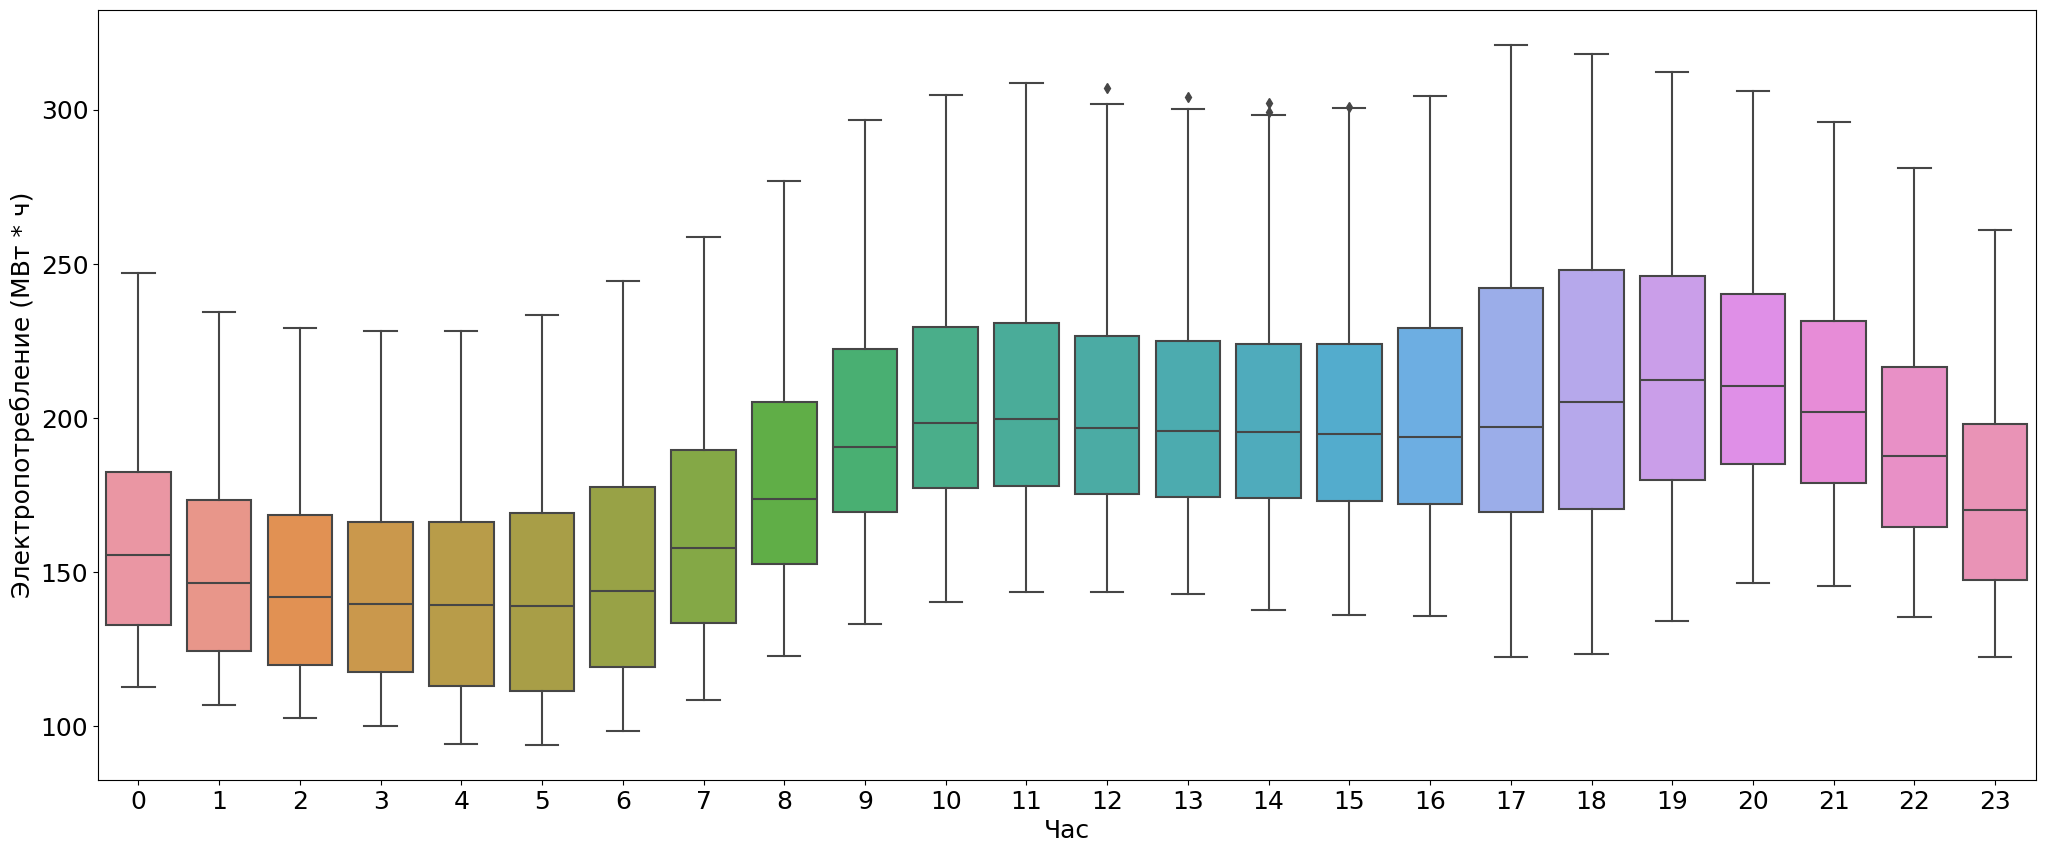

In [23]:
plt.figure(figsize=(25, 10))
sns.boxplot(df, y="Электропотребление", x="Час")
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Час", fontsize=18)
plt.xticks(fontsize=18)
plt.show()

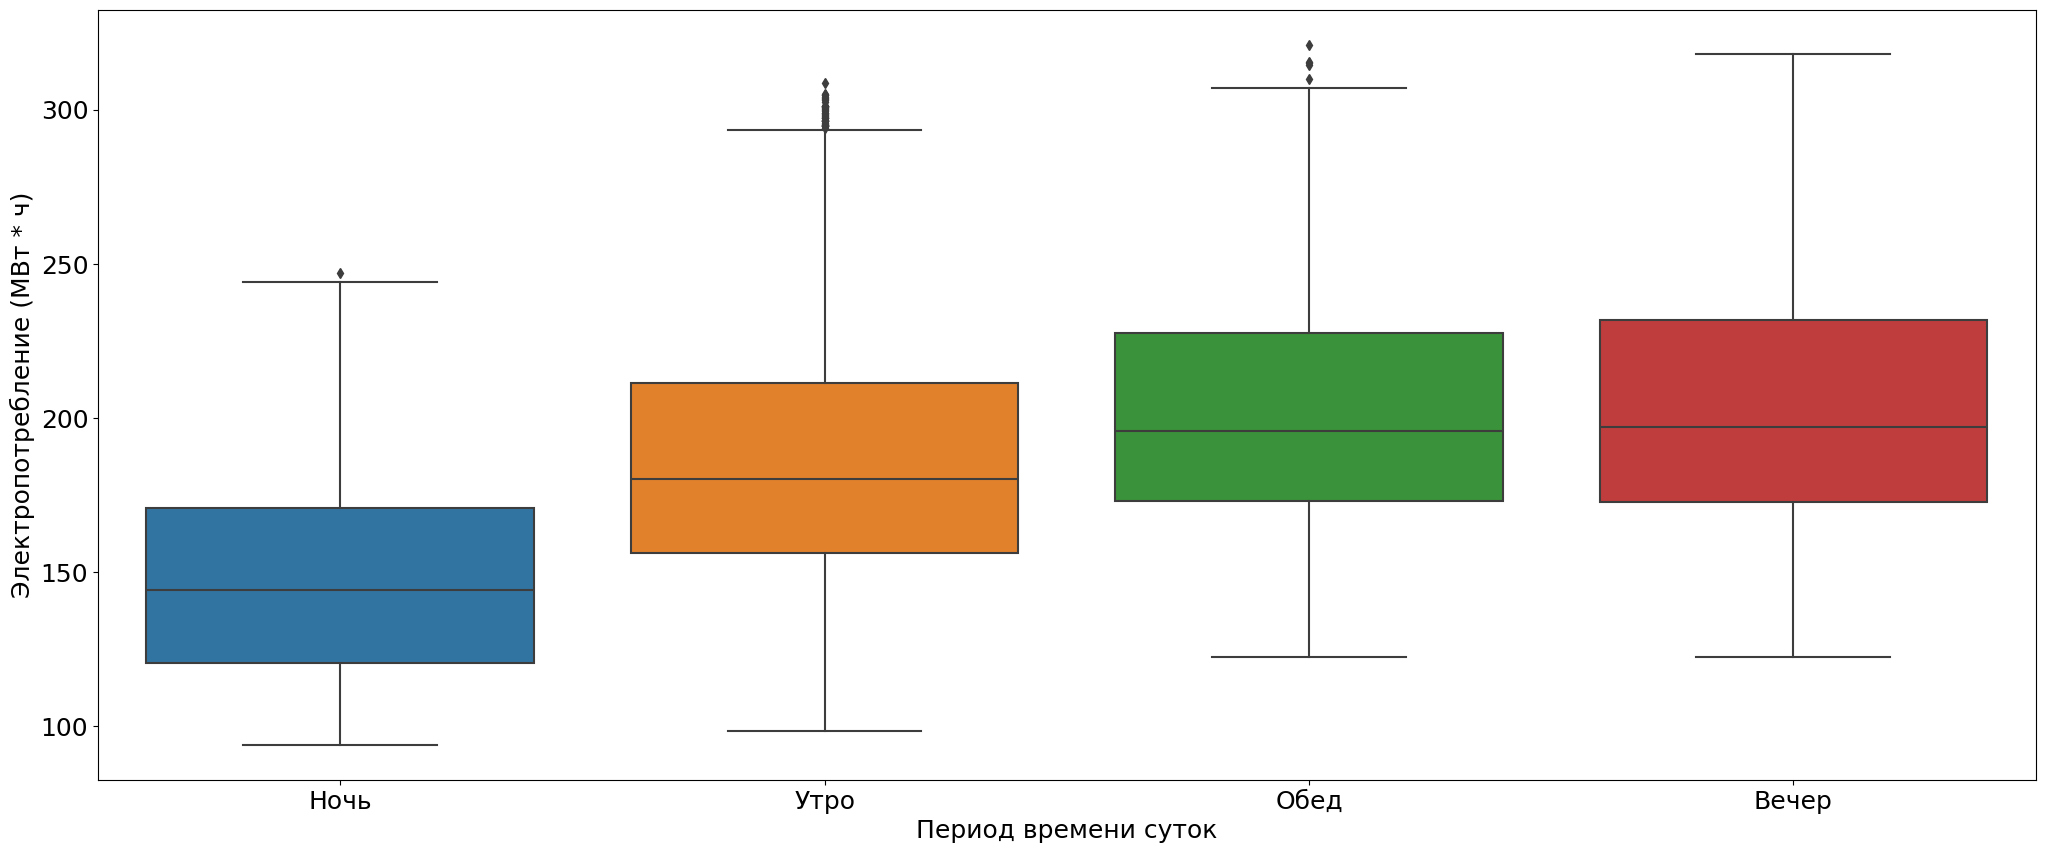

In [24]:
plt.figure(figsize=(25, 10))
fig = sns.boxplot(df, y="Электропотребление", x="Период времени суток")
x_ticks = ["Ночь", "Утро", "Обед", "Вечер"]
fig.set_xticks(range(len(x_ticks)))
fig.set_xticklabels(x_ticks)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Период времени суток", fontsize=18)
plt.xticks(fontsize=18)
plt.show()

<h2>Потребление электроэнергии увеличивается ближе к вечеру.</h2>

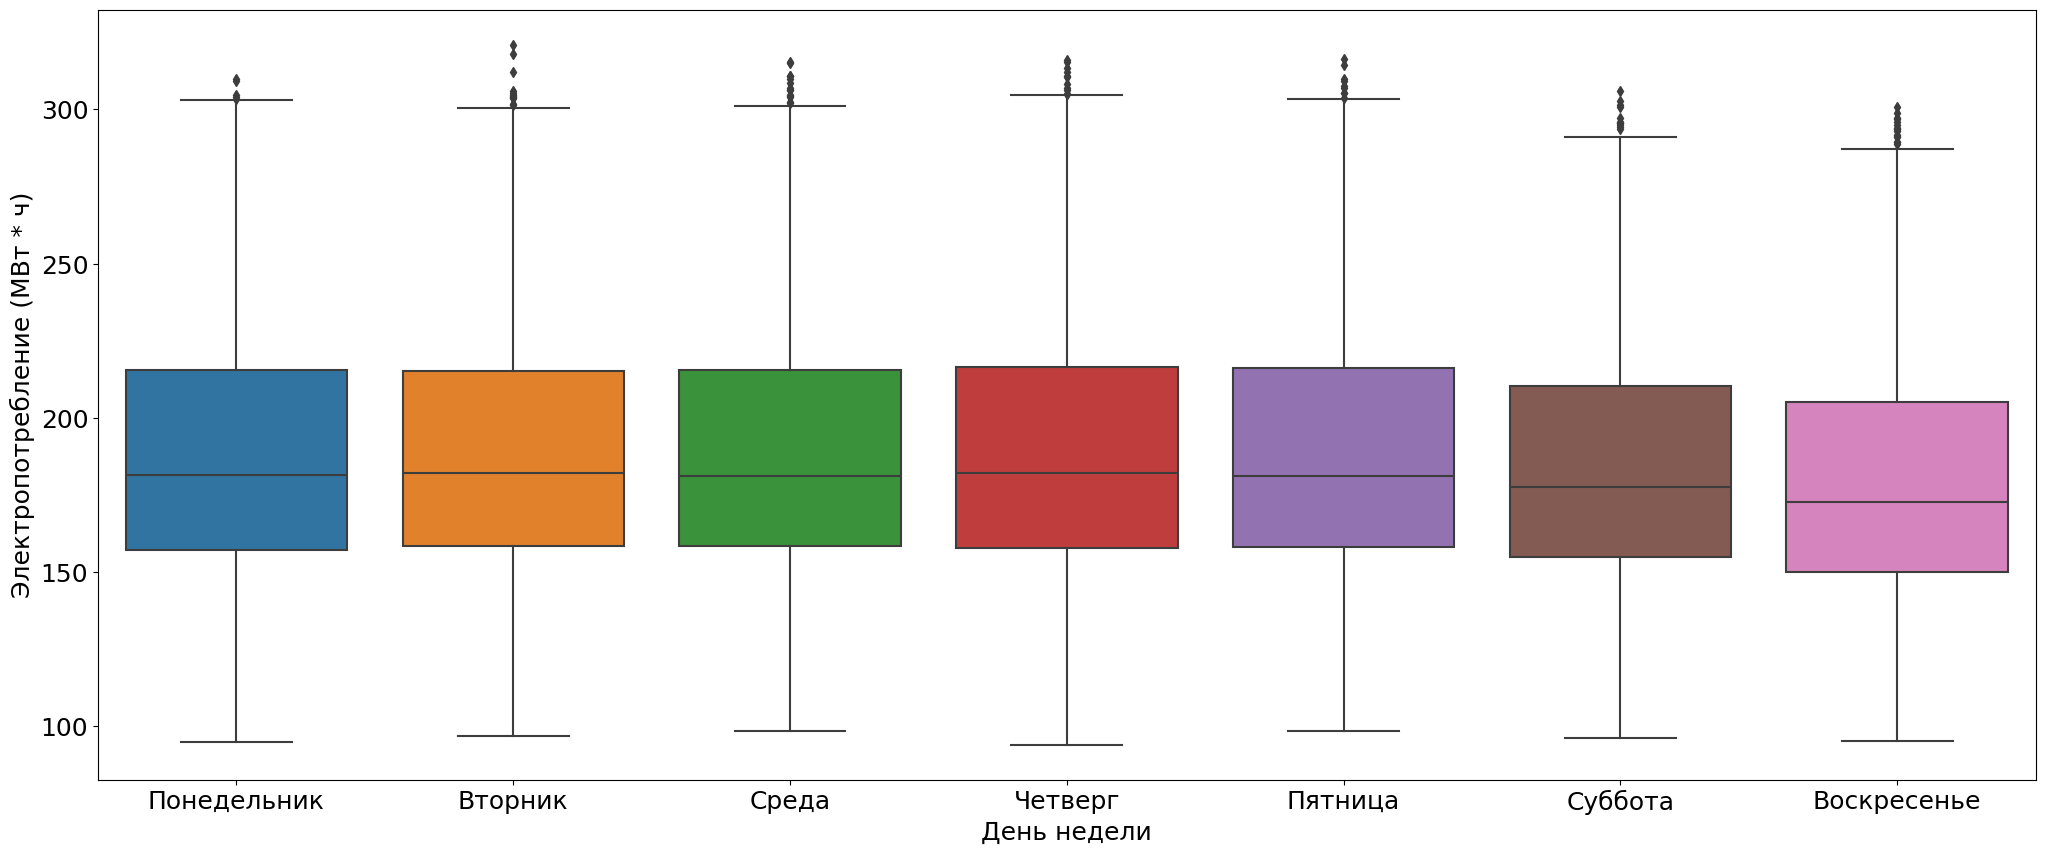

In [25]:
plt.figure(figsize=(25, 10))
fig = sns.boxplot(df, y="Электропотребление", x="День недели")
x_ticks = [
    "Понедельник",
    "Вторник",
    "Среда",
    "Четверг",
    "Пятница",
    "Суббота",
    "Воскресенье"
]
fig.set_xticks(range(len(x_ticks)))
fig.set_xticklabels(x_ticks)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("День недели", fontsize=18)
plt.xticks(fontsize=18)
plt.show()

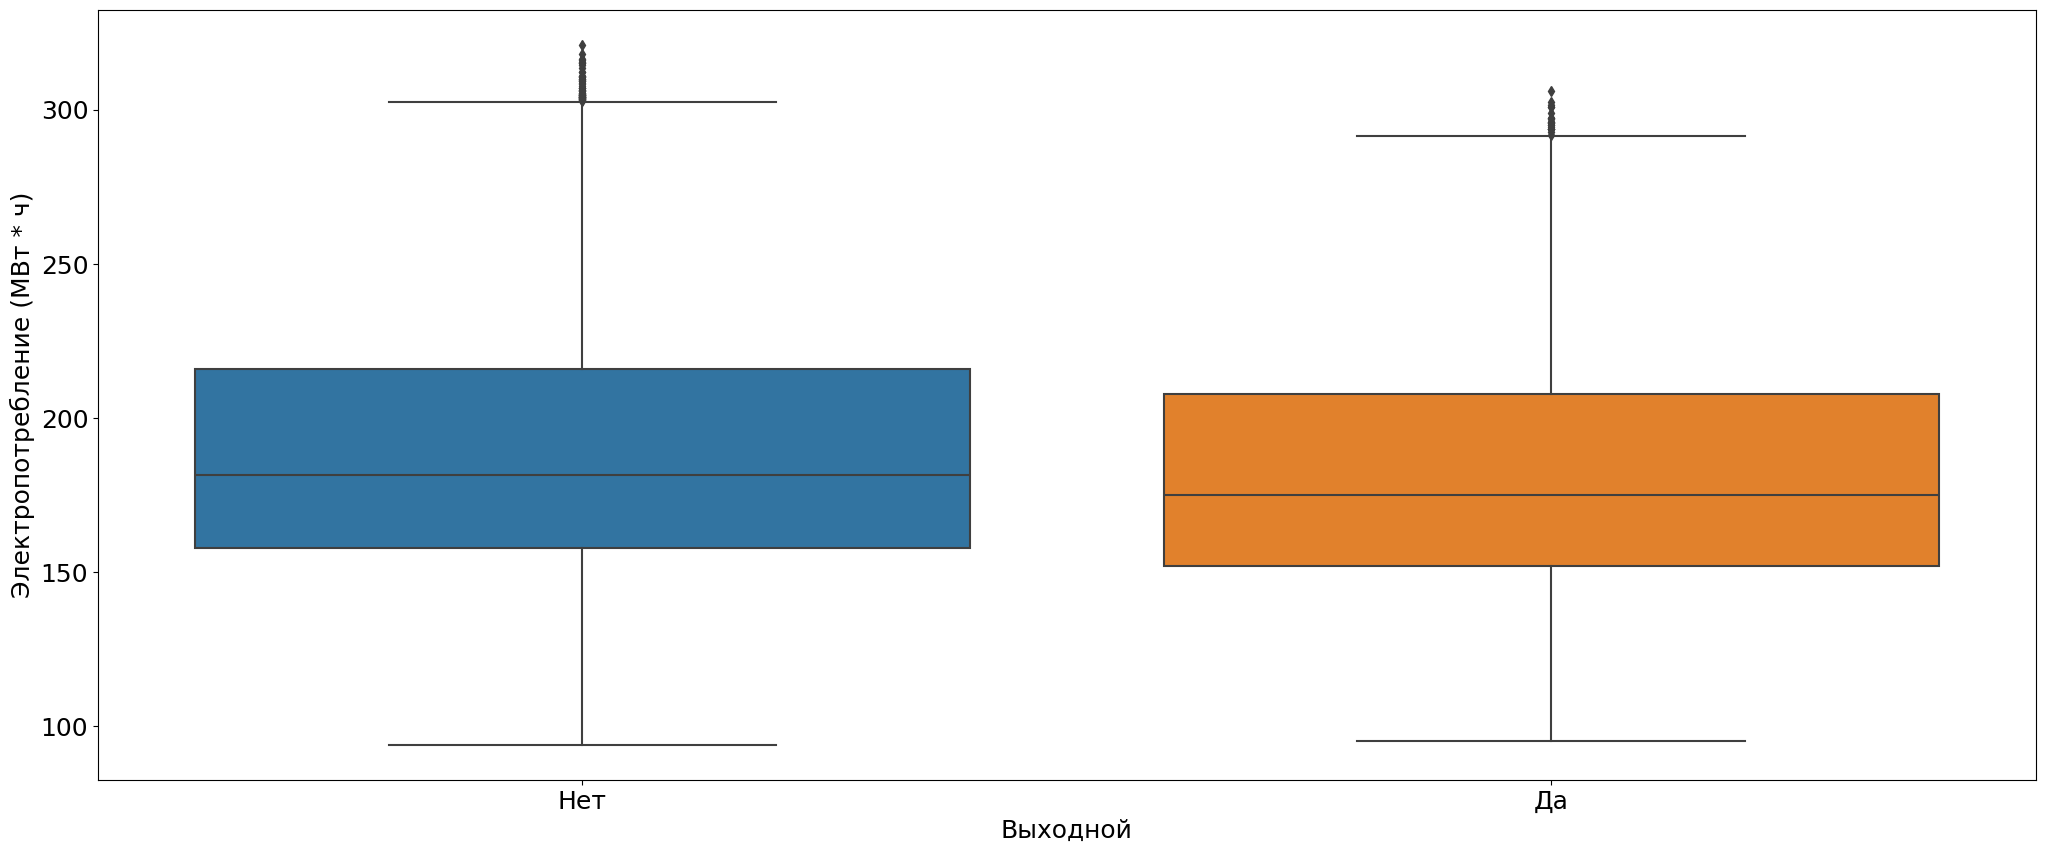

In [26]:
plt.figure(figsize=(25, 10))
fig = sns.boxplot(df, y="Электропотребление", x="Выходной")
x_ticks = ["Нет", "Да"]
fig.set_xticks(range(len(x_ticks)))
fig.set_xticklabels(x_ticks)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Выходной", fontsize=18)
plt.xticks(fontsize=18)
plt.show()

<h2>Потребление электроэнергии уменьшается в выходные.</h2>

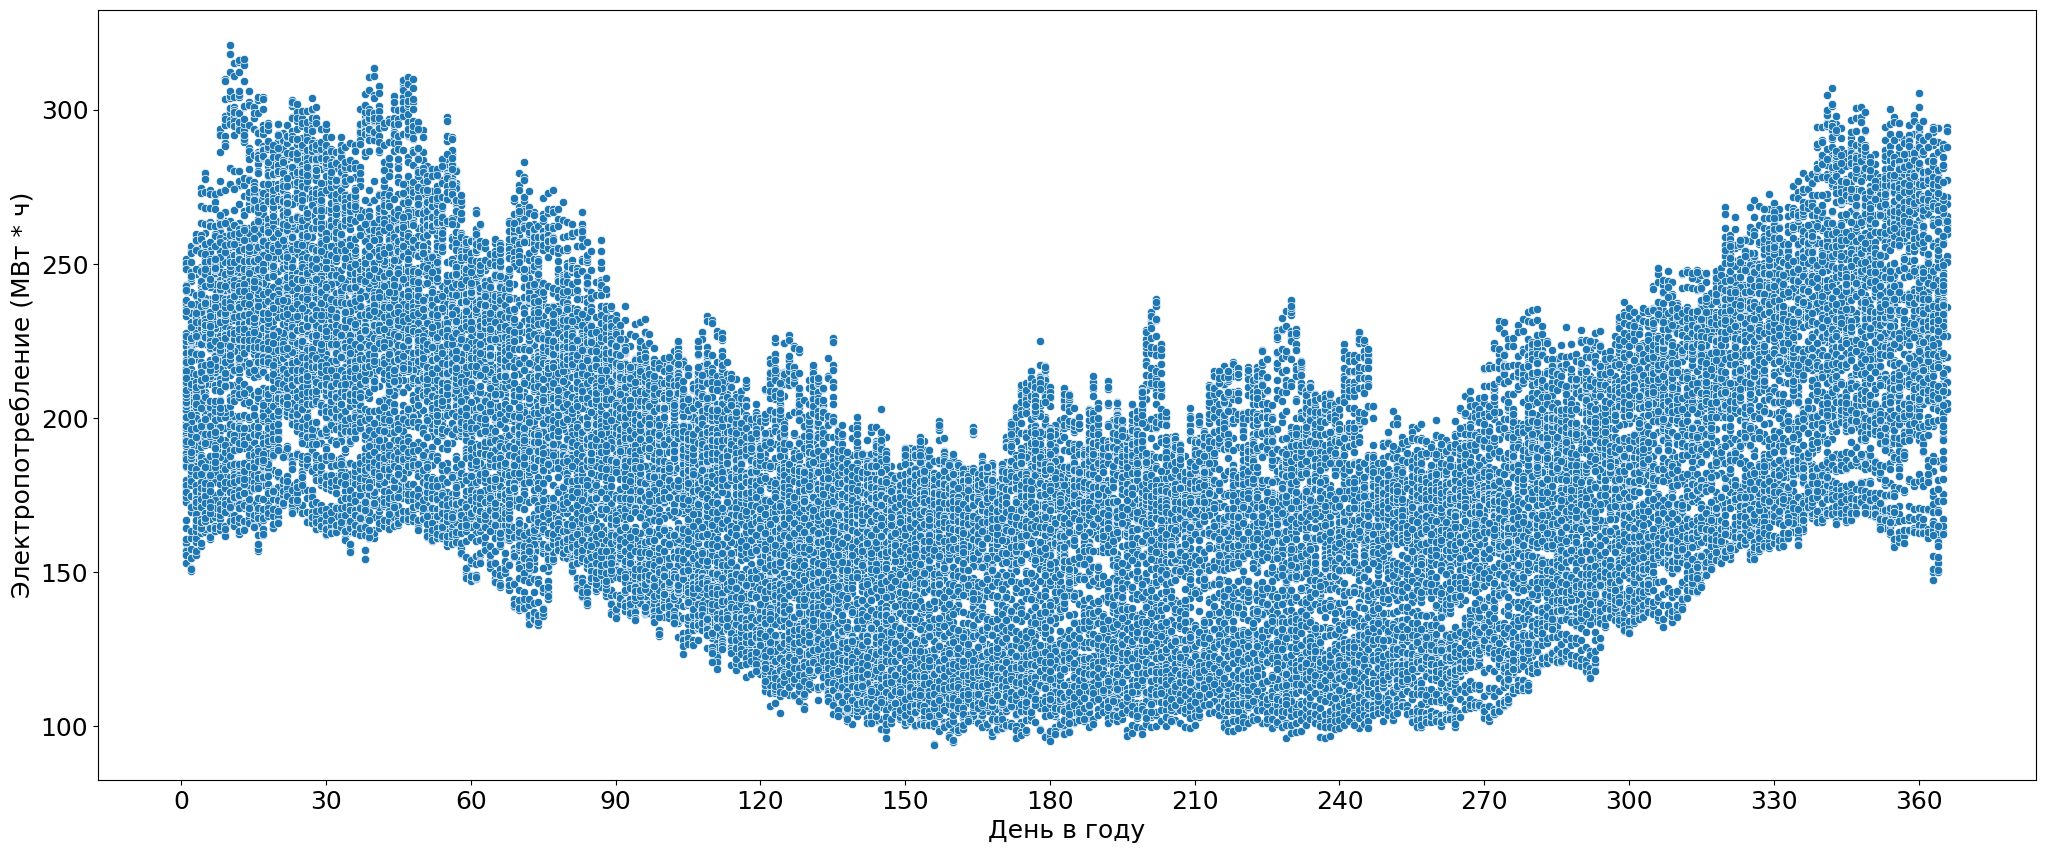

In [27]:
plt.figure(figsize=(25, 10))
sns.scatterplot(df, y="Электропотребление", x="День в году")
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("День в году", fontsize=18)
x_range = np.arange(0, 365, 30)
plt.xticks(x_range, fontsize=18)
plt.show()

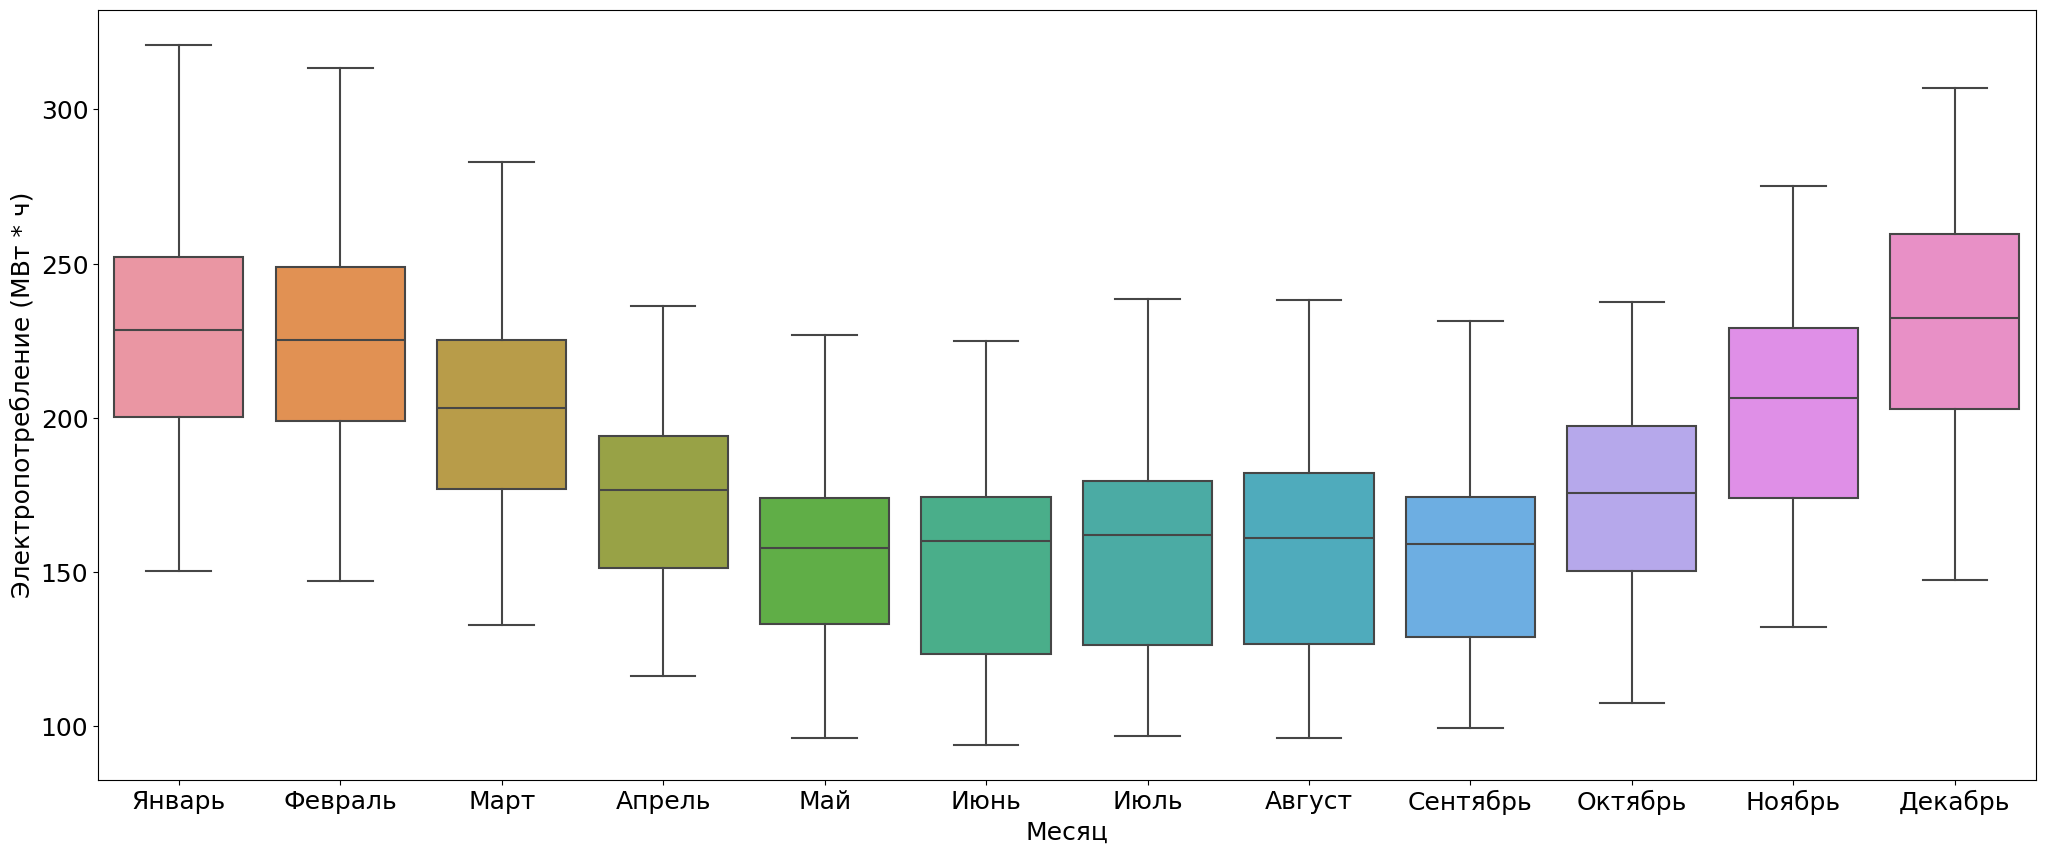

In [28]:
plt.figure(figsize=(25, 10))
fig = sns.boxplot(df, y="Электропотребление", x="Месяц")
x_ticks = [
    "Январь",
    "Февраль",
    "Март",
    "Апрель",
    "Май",
    "Июнь",
    "Июль",
    "Август",
    "Сентябрь",
    "Октябрь",
    "Ноябрь",
    "Декабрь"
]
fig.set_xticks(range(len(x_ticks)))
fig.set_xticklabels(x_ticks)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Месяц", fontsize=18)
plt.xticks(fontsize=18)
plt.show()

<h2>Потребление электроэнергии уменьшается летом и увеличивается к зиме.</h2>

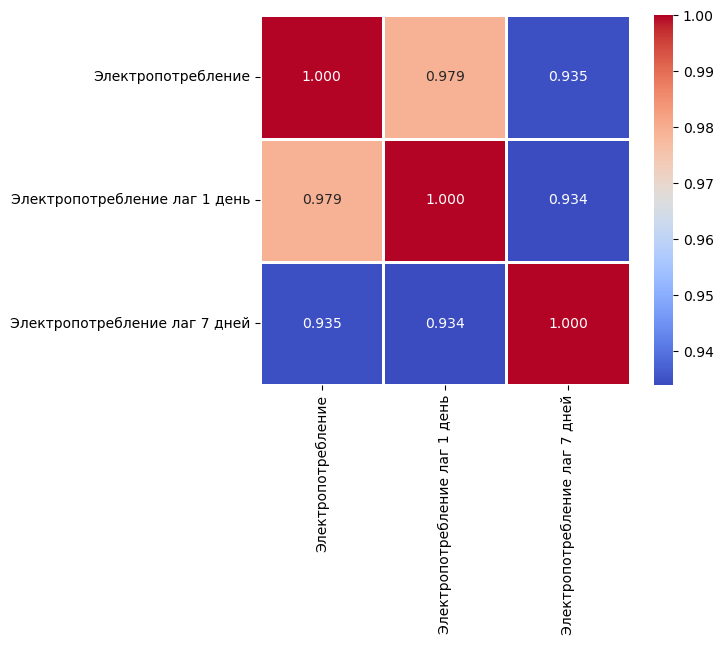

In [16]:
sns.heatmap(
    df.iloc[:, [1, -2, -1]].corr(),
    annot=True,
    square=True,
    cmap="coolwarm",
    linewidths=1,
    fmt=".3f"
)
plt.show()

<h2>Электропотребление имеет сильную корреляцию с дневным и недельным лагом.</h2>

<center>
    <h1><b>Разбиение данных для обучения</b></h1>
</center>

In [121]:
y = df["Электропотребление"]
X = df.drop(columns=["Электропотребление"], axis=0)
X

Час Период времени суток День недели Выходной Месяц  \
Дата и время                                                              
2019-01-08 00:00:00   0                    0           1        0     1   
2019-01-08 01:00:00   1                    0           1        0     1   
2019-01-08 02:00:00   2                    0           1        0     1   
2019-01-08 03:00:00   3                    0           1        0     1   
2019-01-08 04:00:00   4                    0           1        0     1   
...                  ..                  ...         ...      ...   ...   
2023-06-29 19:00:00  19                    3           3        0     6   
2023-06-29 20:00:00  20                    3           3        0     6   
2023-06-29 21:00:00  21                    3           3        0     6   
2023-06-29 22:00:00  22                    3           3        0     6   
2023-06-29 23:00:00  23                    3           3        0     6   

                     День в году  Электропотребление лаг 1 день  \
Дата и время                                                      
2019-01-08 00:00:00            8                        191.298   
2019-01-08 01:00:00            8                        179.960   
2019-01-08 02:00:00            8                        172.706   
2019-01-08 03:00:00            8                        169.160   
2019-01-08 04:00:00            8                        167.794   
...                          ...                            ...   
2023-06-29 19:00:00          180                        171.040   
2023-06-29 20:00:00          180                        183.232   
2023-06-29 21:00:00          180                        177.985   
2023-06-29 22:00:00          180                        164.705   
2023-06-29 23:00:00          180                        148.960   

                     Электропотребление лаг 7 дней  
Дата и время                                        
2019-01-08 00:00:00                        215.191  
2019-01-08 01:00:00                        202.239  
2019-01-08 02:00:00                        188.462  
2019-01-08 03:00:00                        179.276  
2019-01-08 04:00:00                        173.035  
...                                            ...  
2023-06-29 19:00:00                        167.809  
2023-06-29 20:00:00                        177.173  
2023-06-29 21:00:00                        172.780  
2023-06-29 22:00:00                        158.533  
2023-06-29 23:00:00                        144.961  

[39216 rows x 8 columns]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
X_train

Час Период времени суток День недели Выходной Месяц  \
Дата и время                                                              
2019-01-08 00:00:00   0                    0           1        0     1   
2019-01-08 01:00:00   1                    0           1        0     1   
2019-01-08 02:00:00   2                    0           1        0     1   
2019-01-08 03:00:00   3                    0           1        0     1   
2019-01-08 04:00:00   4                    0           1        0     1   
...                  ..                  ...         ...      ...   ...   
2022-08-06 23:00:00  23                    3           5        1     8   
2022-08-07 00:00:00   0                    0           6        1     8   
2022-08-07 01:00:00   1                    0           6        1     8   
2022-08-07 02:00:00   2                    0           6        1     8   
2022-08-07 03:00:00   3                    0           6        1     8   

                     День в году  Электропотребление лаг 1 день  \
Дата и время                                                      
2019-01-08 00:00:00            8                        191.298   
2019-01-08 01:00:00            8                        179.960   
2019-01-08 02:00:00            8                        172.706   
2019-01-08 03:00:00            8                        169.160   
2019-01-08 04:00:00            8                        167.794   
...                          ...                            ...   
2022-08-06 23:00:00          218                        151.210   
2022-08-07 00:00:00          219                        138.811   
2022-08-07 01:00:00          219                        130.961   
2022-08-07 02:00:00          219                        126.759   
2022-08-07 03:00:00          219                        123.501   

                     Электропотребление лаг 7 дней  
Дата и время                                        
2019-01-08 00:00:00                        215.191  
2019-01-08 01:00:00                        202.239  
2019-01-08 02:00:00                        188.462  
2019-01-08 03:00:00                        179.276  
2019-01-08 04:00:00                        173.035  
...                                            ...  
2022-08-06 23:00:00                        160.502  
2022-08-07 00:00:00                        145.668  
2022-08-07 01:00:00                        133.815  
2022-08-07 02:00:00                        126.943  
2022-08-07 03:00:00                        123.053  

[31372 rows x 8 columns]

In [123]:
categorical_features = [
    "Период времени суток",
    "Час",
    "Месяц",
    "День недели",
    "Выходной",
    "День в году"
]
categorical_features

['Период времени суток',
 'Час',
 'Месяц',
 'День недели',
 'Выходной',
 'День в году']

<center><h1><b>Подбор гиперпараметров</b></h1></center>

<center><h2>Начальное значение n_estimators</h2></center>

In [22]:
X_trainLGB = Dataset(
    data=X_train, label=y_train, categorical_feature=categorical_features
)

main_params = {"objective": "regression", "force_col_wise": "true", "random_state": 1, "verbose": -1}
tscv = TimeSeriesSplit(test_size=24 * 30 * 3, n_splits=5, gap=24 * 5)

cv_results = cv(
    main_params,
    X_trainLGB,
    num_boost_round=5000,
    folds=tscv,
    stratified=False,
    shuffle=False,
    metrics="mae",
    categorical_feature=categorical_features,
    callbacks=[early_stopping(50)],
    eval_train_metric=True
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	cv_agg's train l1: 2.96414 + 0.0736691	cv_agg's valid l1: 5.87701 + 0.659416


<center><h2>max_depth</h2></center>

In [16]:
lgb_model = LGBMRegressor(n_estimators=58, random_state=1, bagging_freq=1, n_jobs=-1, verbose=-1)
params = {"max_depth": range(5, 21)}

grid = GridSearchCV(lgb_model, params, scoring="neg_mean_absolute_error", cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=120, max_train_size=None, n_splits=5, test_size=2160),
             estimator=LGBMRegressor(bagging_freq=1, n_estimators=58, n_jobs=-1,
                                     random_state=1, verbose=-1),
             param_grid={'max_depth': range(5, 21)},
             scoring='neg_mean_absolute_error')

In [18]:
grid.best_params_

{'max_depth': 10}

In [24]:
main_params["max_depth"] = 10
main_params

{'objective': 'regression',
 'force_col_wise': 'true',
 'random_state': 1,
 'verbose': -1,
 'max_depth': 10}

<center><h2>Обновлённое значение n_estimators</h2></center>

In [25]:
cv_results = cv(
    main_params,
    X_trainLGB,
    num_boost_round=5000,
    folds=tscv,
    stratified=False,
    shuffle=False,
    metrics="mae",
    categorical_feature=categorical_features,
    callbacks=[early_stopping(50)],
    eval_train_metric=True
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	cv_agg's train l1: 2.99986 + 0.078535	cv_agg's valid l1: 5.87132 + 0.655202


<center><h1><b>Обучение</b></h1></center>

In [124]:
lgbm = LGBMRegressor(
    n_estimators=57,
    max_depth=10,
    bagging_freq=1,
    importance_type="gain",
    random_state=1,
    force_row_wise=True,
    n_jobs=-1,
    verbose=-1
)
lgbm.fit(X_train, y_train)

LGBMRegressor(bagging_freq=1, force_row_wise=True, importance_type='gain',
              max_depth=10, n_estimators=57, n_jobs=-1, random_state=1,
              verbose=-1)

In [125]:
data = pd.DataFrame(
    data=np.round(lgbm.feature_importances_ / lgbm.feature_importances_.sum() * 100, 3),
    index=X_train.columns,
    columns=["information gain (%)"]
).sort_values(by="information gain (%)", ascending=False)
data

information gain (%)
Электропотребление лаг 1 день                97.189
Электропотребление лаг 7 дней                 1.119
День недели                                   0.460
Час                                           0.373
День в году                                   0.350
Выходной                                      0.265
Месяц                                         0.158
Период времени суток                          0.088

In [126]:
data: pd.DataFrame = pd.DataFrame(
    data=np.round(lgbm.feature_importances_),
    index=X_train.columns,
    columns=["information gain"]
).sort_values(by="information gain", ascending=False)
data

information gain
Электропотребление лаг 1 день       268591365.0
Электропотребление лаг 7 дней         3091221.0
День недели                           1271155.0
Час                                   1029471.0
День в году                            966774.0
Выходной                               732946.0
Месяц                                  436030.0
Период времени суток                   241816.0

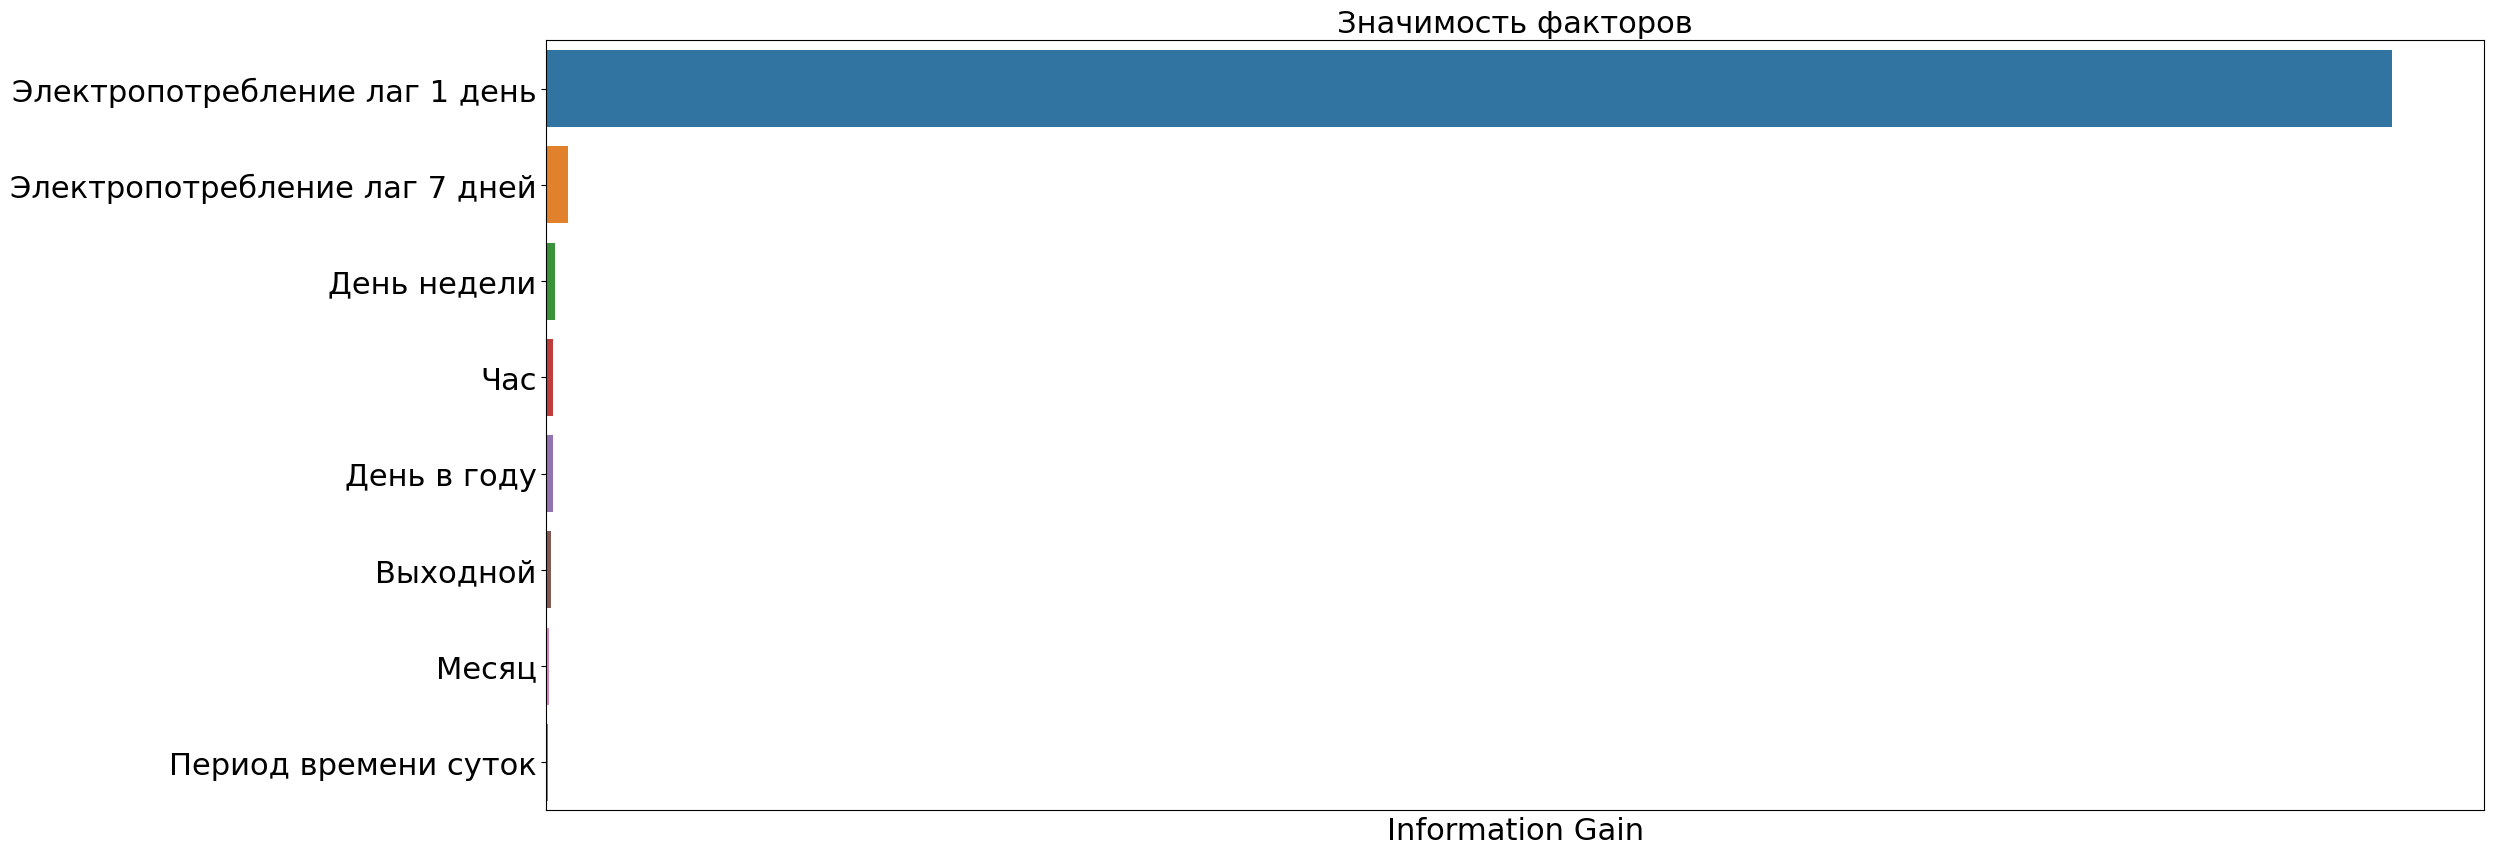

In [127]:
plt.figure(figsize=(25, 10))
ax2 = sns.barplot(data=data, x="information gain", y=data.index)
ax2.xaxis.set_major_locator(NullLocator())
plt.title("Значимость факторов", fontsize=22)
plt.xlabel("Information Gain", fontsize=22)
plt.yticks(fontsize=22)
plt.show()

<h2>Лаговые переменные имеют максимальную значимость (98 %).</h2>

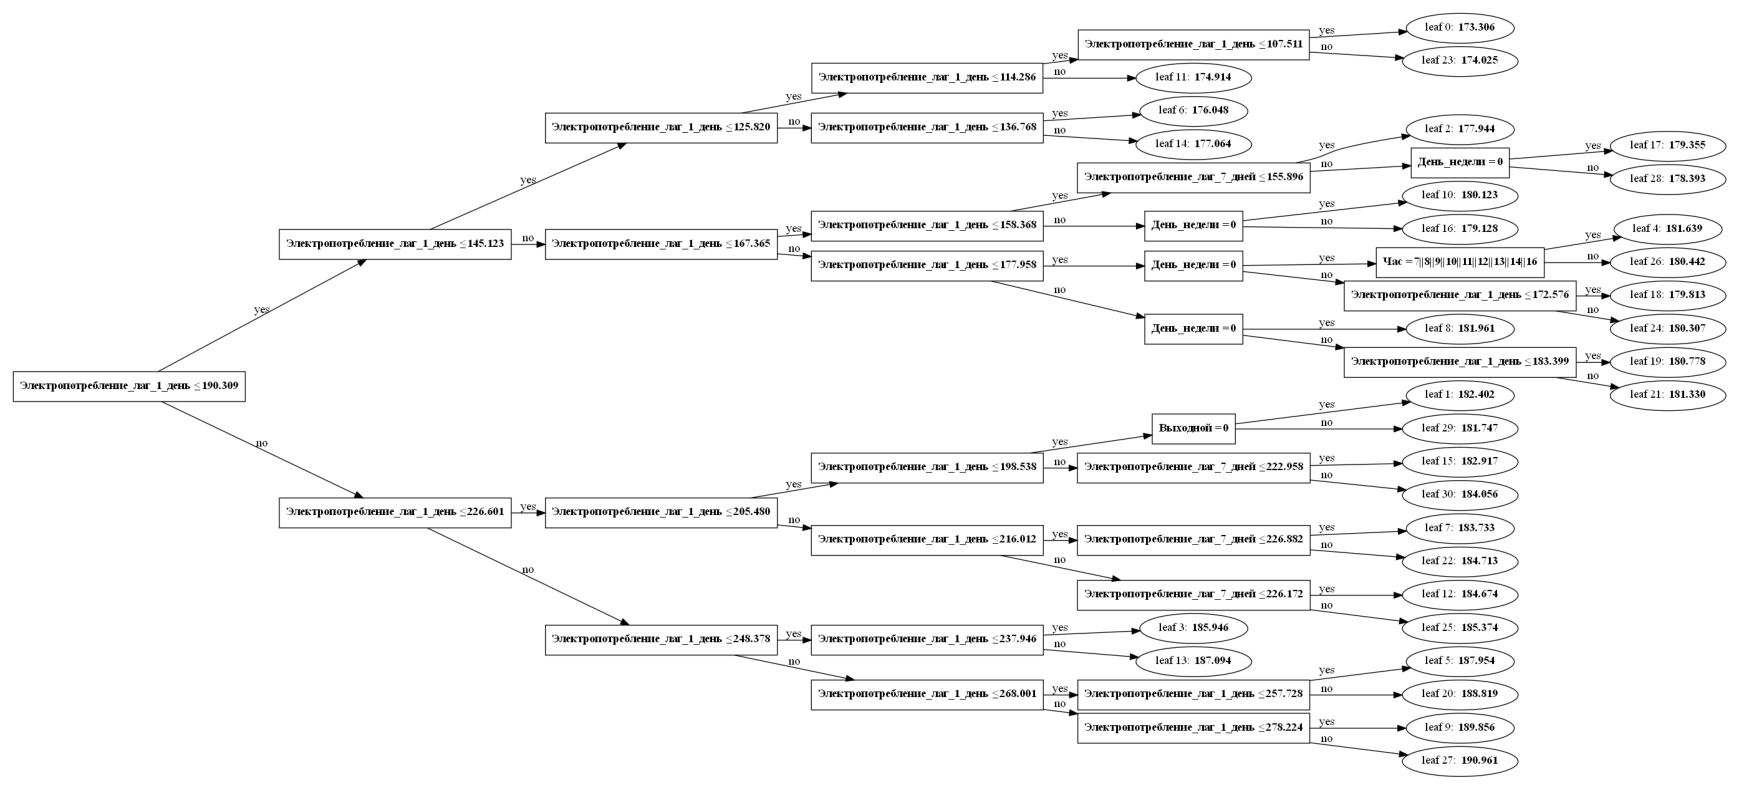

In [26]:
plot_tree(lgbm, figsize=(25, 10))
plt.show()

<center><h1><b>Оценка модели</b></h1></center>

In [128]:
def evaluate(y_true: np.array, y_pred: np.array, feautures_count: int) -> None:
    """
    Выводит регрессионные метрики качества:
    - RMSE
    - MAE
    - MAPE
    - Adjusted R^2
    Parameters
    ----------
    y_true : numpy.array
        Фактические значения целевой переменной.
    y_pred : numpy.array
        Прогнозные значения целевой переменной.
    feautures_count : int
        Количество факторов.
    """
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    print(f"RMSE равняется {RMSE:.3f}")
    MAE = mean_absolute_error(y_true, y_pred)
    print(f"MAE равняется {MAE:.3f}")
    MAPE = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"MAPE равняется {MAPE:.3f} %")
    N = len(y_pred)
    R2 = r2_score(y_true, y_pred)
    Adj_R2 = 1 - (1 - R2) * (N - 1) / (N - feautures_count - 1)
    print(f"Adjusted R2 равняется {Adj_R2:.3f}")

<center><h2>Метрики на обучающей выборке</h2></center>

In [129]:
y_pred_train = np.round(lgbm.predict(X_train), 3)
evaluate(y_train, y_pred_train, len(X_train.columns))

RMSE равняется 6.180
MAE равняется 4.493
MAPE равняется 2.490 %
Adjusted R2 равняется 0.978


<center><h2>Метрики на валидации</h2></center>

In [20]:
def time_series_cv(model, X:pd.DataFrame, y: np.array) -> None:
    """
    Выводит регрессионные метрики качества на кросс-валидации на скользящем окне:
    - RMSE
    - MAE
    - MAPE
    - R^2

    Parameters
    ----------
    model : sklearn.Regressor
        Математическая модель.
    X : pd.DataFrame
        Матрица входных признаков.
    y : pd.Series
        Целевая переменная.
    """

    tscv = TimeSeriesSplit(test_size=24 * 30 * 3, n_splits=5, gap=24 * 5)
    metrics = {
        "neg_root_mean_squared_error": "RMSE",
        "neg_mean_absolute_error": "MAE",
        "neg_mean_absolute_percentage_error": "MAPE",
        "r2": "R2 adj"
    }
    for scikit_learn_metric, ds_metric in metrics.items():
        val_score = cross_val_score(
            model, X, y, scoring=scikit_learn_metric, cv=tscv, n_jobs=-1
        )
        if scikit_learn_metric in (
            "neg_root_mean_squared_error",
            "neg_mean_absolute_error"
        ):
            print(
                f"{ds_metric} = {np.round(np.abs(val_score).mean(), 3)} +- {np.round(np.abs(val_score).std(), 3)}"
            )
        elif scikit_learn_metric == "neg_mean_absolute_percentage_error":
            print(
                f"{ds_metric} = {np.round(np.abs(val_score).mean() * 100, 3)} +- {np.round(np.abs(val_score).std() * 100, 3)}"
            )
        elif scikit_learn_metric == "r2":
            print(
                f"{ds_metric} = {np.round(val_score.mean(), 3)} +- {np.round(val_score.std(), 3)}"
            )

In [21]:
time_series_cv(lgbm, X_train, y_train)

RMSE = 7.49 +- 0.889
MAE = 5.328 +- 0.544
MAPE = 2.893 +- 0.388
R2 adj = 0.944 +- 0.016


<center><h2>Метрики на тестовой выборке</h2></center>

In [130]:
y_pred_test = np.round(lgbm.predict(X_test), 3)
evaluate(y_test, y_pred_test, len(X_test.columns))

RMSE равняется 8.172
MAE равняется 5.777
MAPE равняется 2.847 %
Adjusted R2 равняется 0.970


<center><h2>Метрики качества модели </h2>
<table>
  <tr>
    <td></td>
    <td><b>Train</b></td>
    <td><b>Validation</b></td>
    <td><b>Test</b></td>
  </tr>
  <tr>
    <td><b>RMSE</b></td>
    <td>6.180</td>
    <td>7.490</td>
    <td>8.172</td>
  </tr>
  <tr>
    <td><b>MAE</b></td>
    <td>4.493</td>
    <td>5.328</td>
    <td>5.777</td>
  </tr>
  <tr>
    <td><b>MAPE (%)</b></td>
    <td>2.490</td>
    <td>2.893</td>
    <td>2.847</td>
  </tr>
  <tr>
    <td><b>R<sup>2</sup><sub>adj</sub></b></td>
    <td>0.978</td>
    <td>0.944</td>
    <td>0.970</td>
  </tr>
</table></center>

<h2>Показатели на обучающей и на тестовой выборке не значимо отличаются друг от друга.</h2>

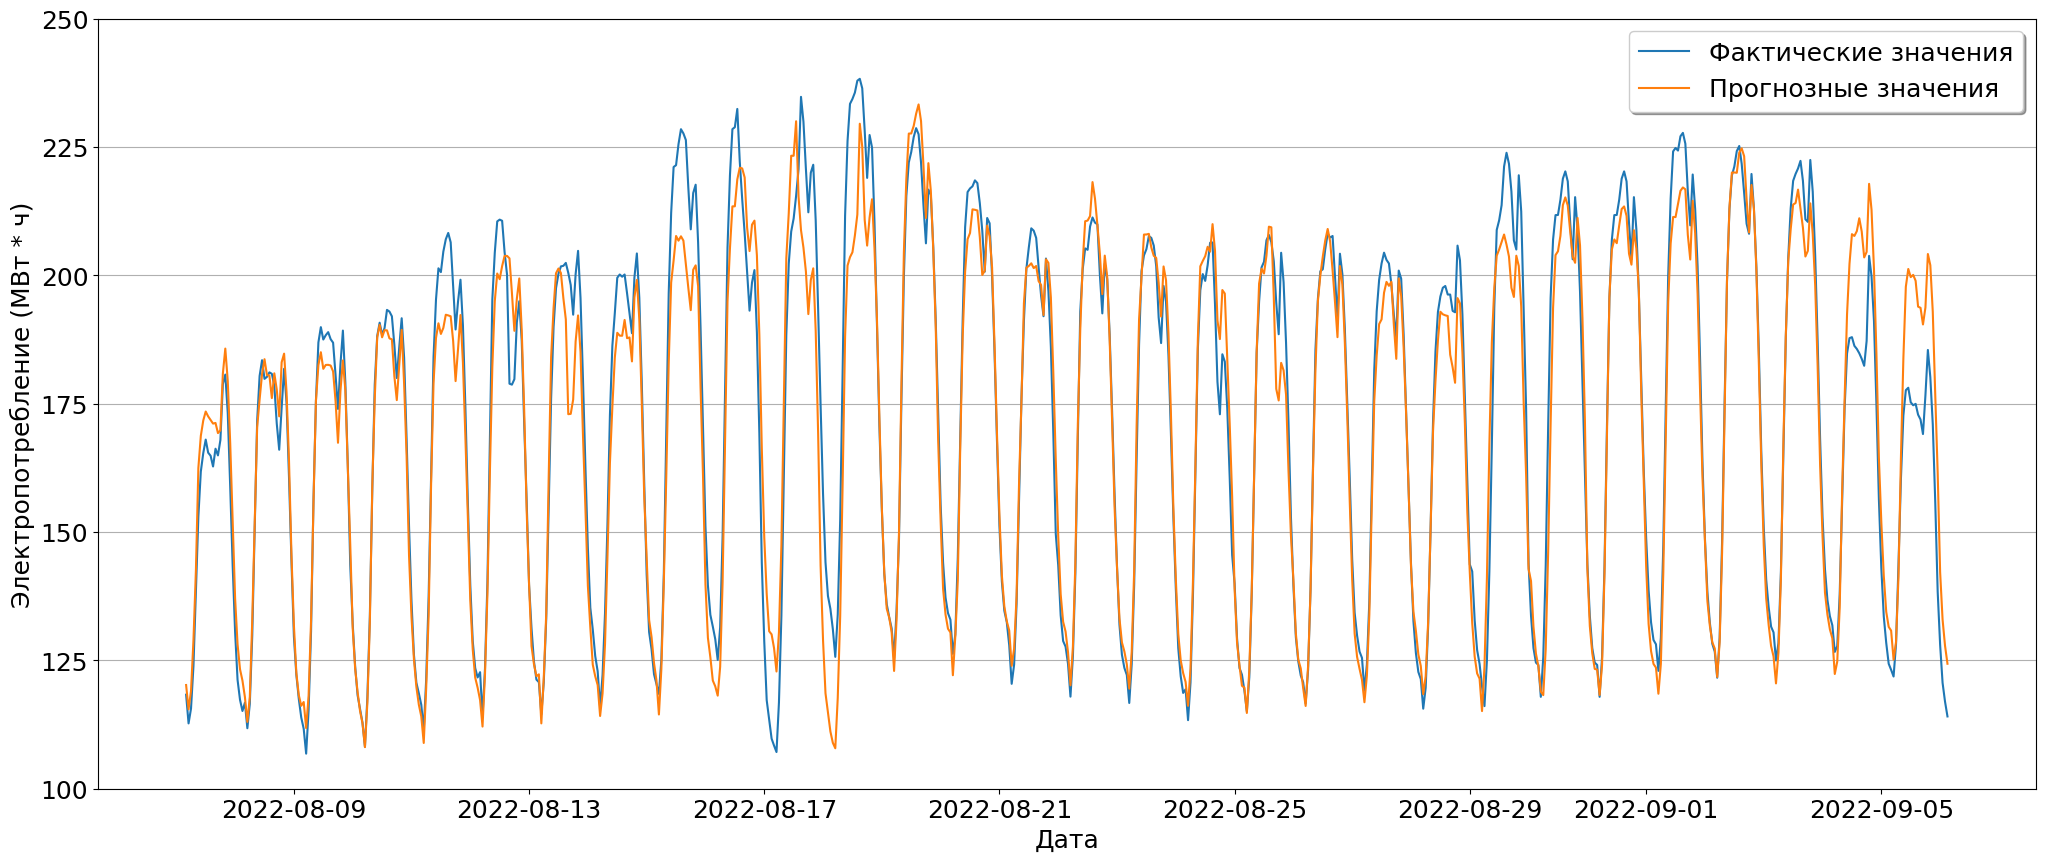

In [131]:
plt.figure(figsize=(25, 10))
horizon_size: int = 24 * 30
plt.plot(y_test[:horizon_size], label="Фактические значения")
plt.plot(y_test[:horizon_size].index, y_pred_test[:horizon_size], label="Прогнозные значения")
plt.yticks(np.arange(100, 275, 25), fontsize=18)
plt.ylabel("Электропотребление (МВт * ч)", fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("Дата", fontsize=18)
plt.legend(loc="best", fontsize=18, shadow=True)
plt.grid(axis="y")
plt.show()

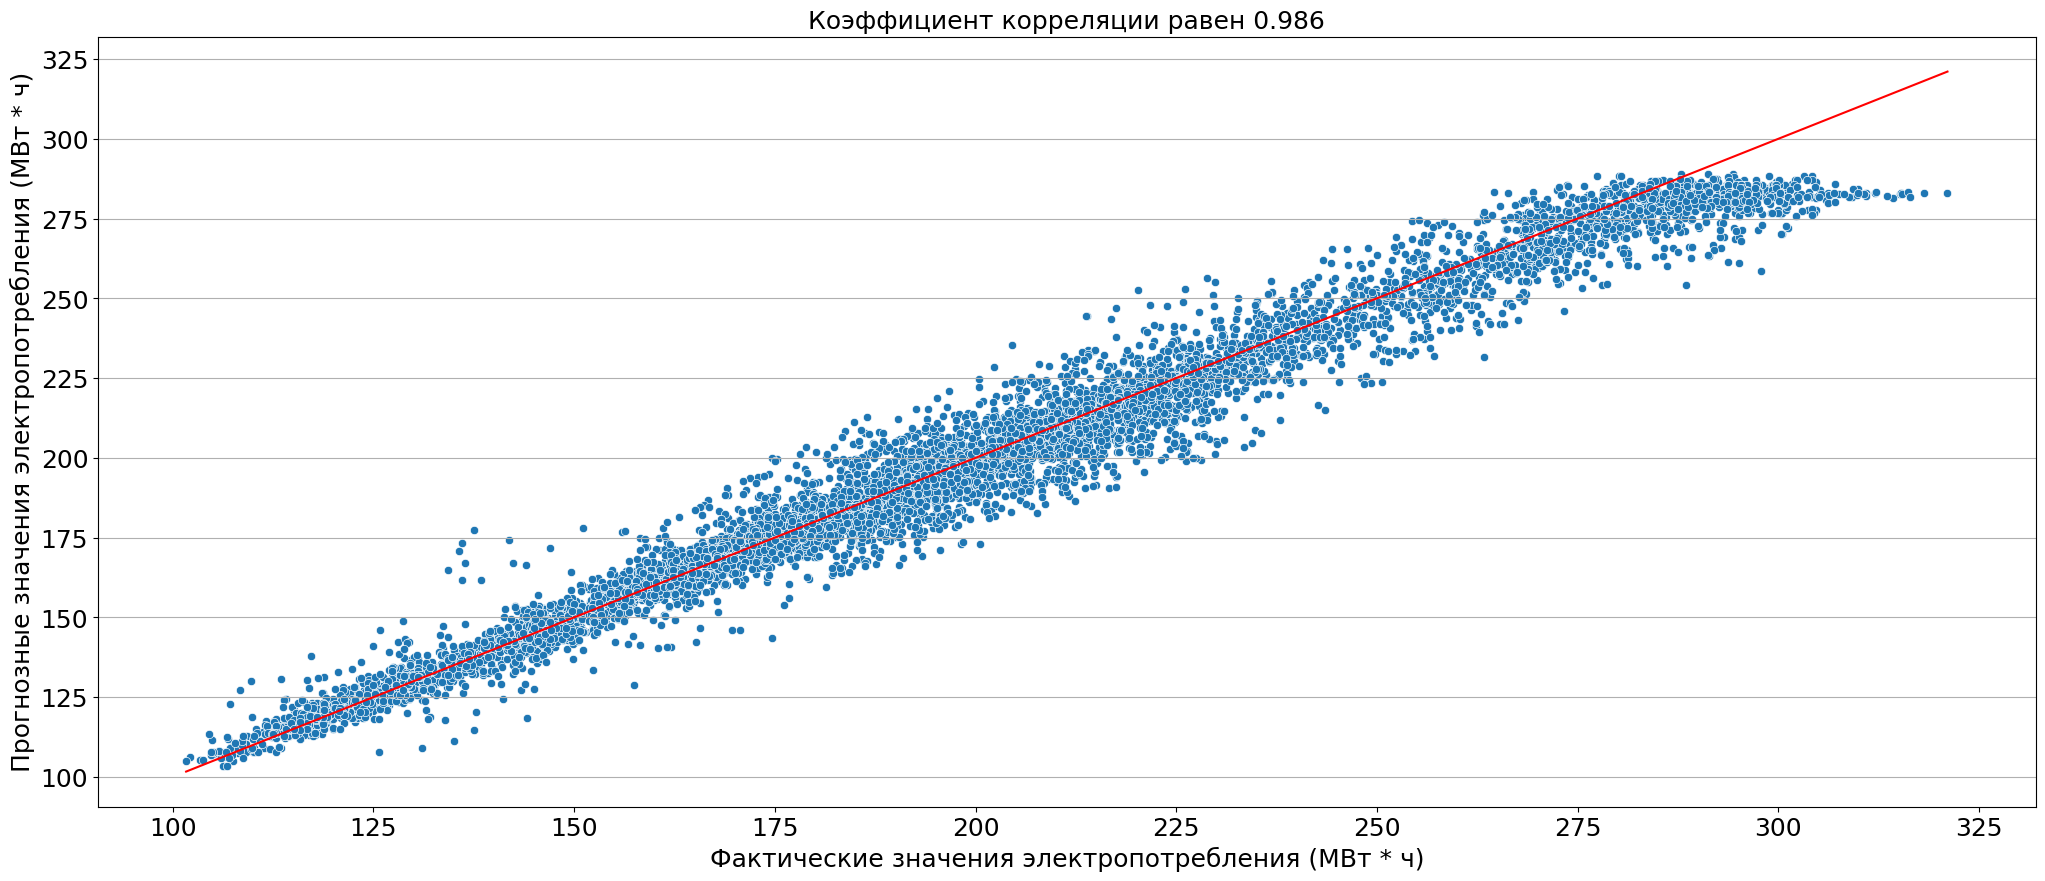

In [132]:
coef_corr: float = np.corrcoef(y_test.values, y_pred_test)[0, 1]
plt.figure(figsize=(25, 10))
plt.title(f"Коэффициент корреляции равен {coef_corr:.3f}", fontsize=18)
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel("Фактические значения электропотребления (МВт * ч)", fontsize=18)
plt.ylabel("Прогнозные значения электропотребления (МВт * ч)", fontsize=18)
plt.xticks(np.arange(100, 350, 25), fontsize=18)
plt.yticks(np.arange(100, 350, 25), fontsize=18)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.grid(axis="y")
plt.show()

<h2>
    Фактические и прогнозные значения не сильно отклоняются друг от друга.<br>
    Коэффициент линейной корреляции Пирсона близок к единице.
</h2>

<center><h1><b>Анализ остатков</b></h1></center>

In [133]:
errors: pd.Series = np.round(y_test - y_pred_test, 3)
errors

Дата и время
2022-08-07 04:00:00   -1.880
2022-08-07 05:00:00   -2.739
2022-08-07 06:00:00   -3.425
2022-08-07 07:00:00   -5.030
2022-08-07 08:00:00   -3.826
                       ...  
2023-06-29 19:00:00    5.143
2023-06-29 20:00:00    6.708
2023-06-29 21:00:00    5.831
2023-06-29 22:00:00    6.255
2023-06-29 23:00:00    4.037
Name: Электропотребление, Length: 7844, dtype: float64

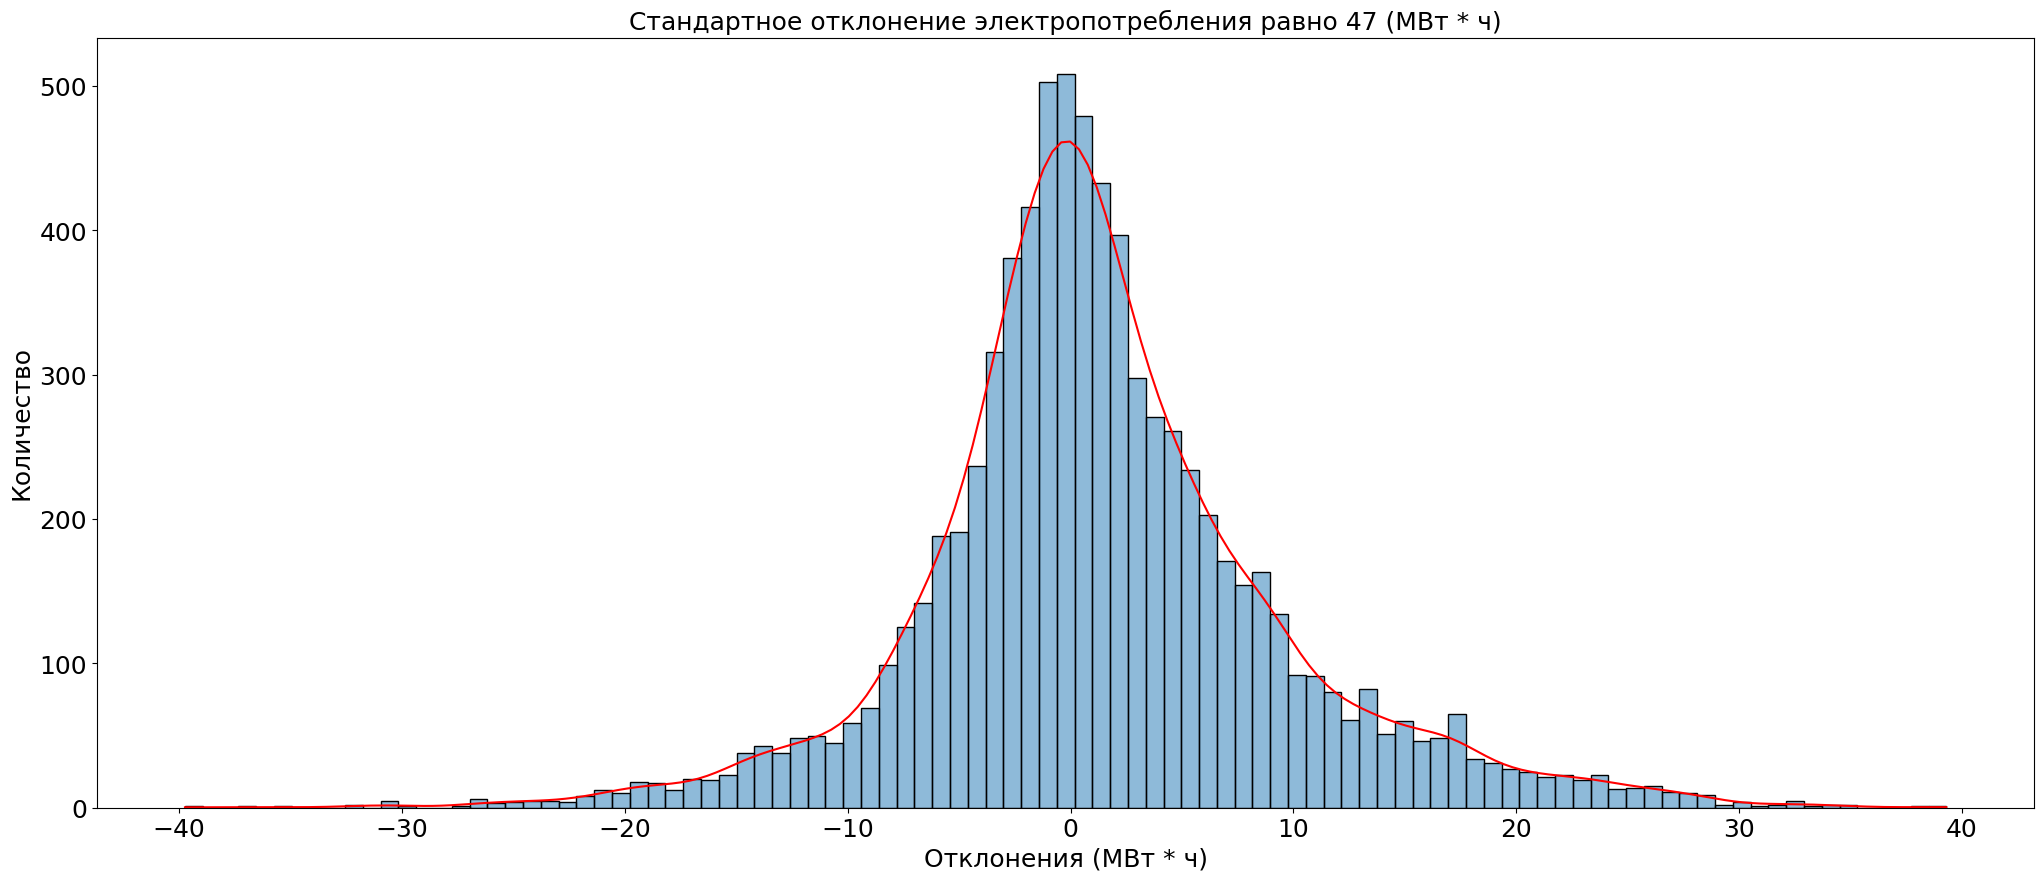

In [134]:
plt.figure(figsize=(25, 10))
ax = sns.histplot(x=errors, kde=True)
ax.lines[0].set_color("red")
plt.title(
    f"Стандартное отклонение электропотребления равно {round(y_test.std())} (МВт * ч)", fontsize=18
)
plt.xticks(np.arange(-40, 50, 10), fontsize=18)
plt.xlabel("Отклонения (МВт * ч)", fontsize=18)
plt.yticks(np.arange(0, 600, 100), fontsize=18)
plt.ylabel("Количество", fontsize=18)
plt.show()

<h2>Отклонения не превышают 1 sd.</h2>

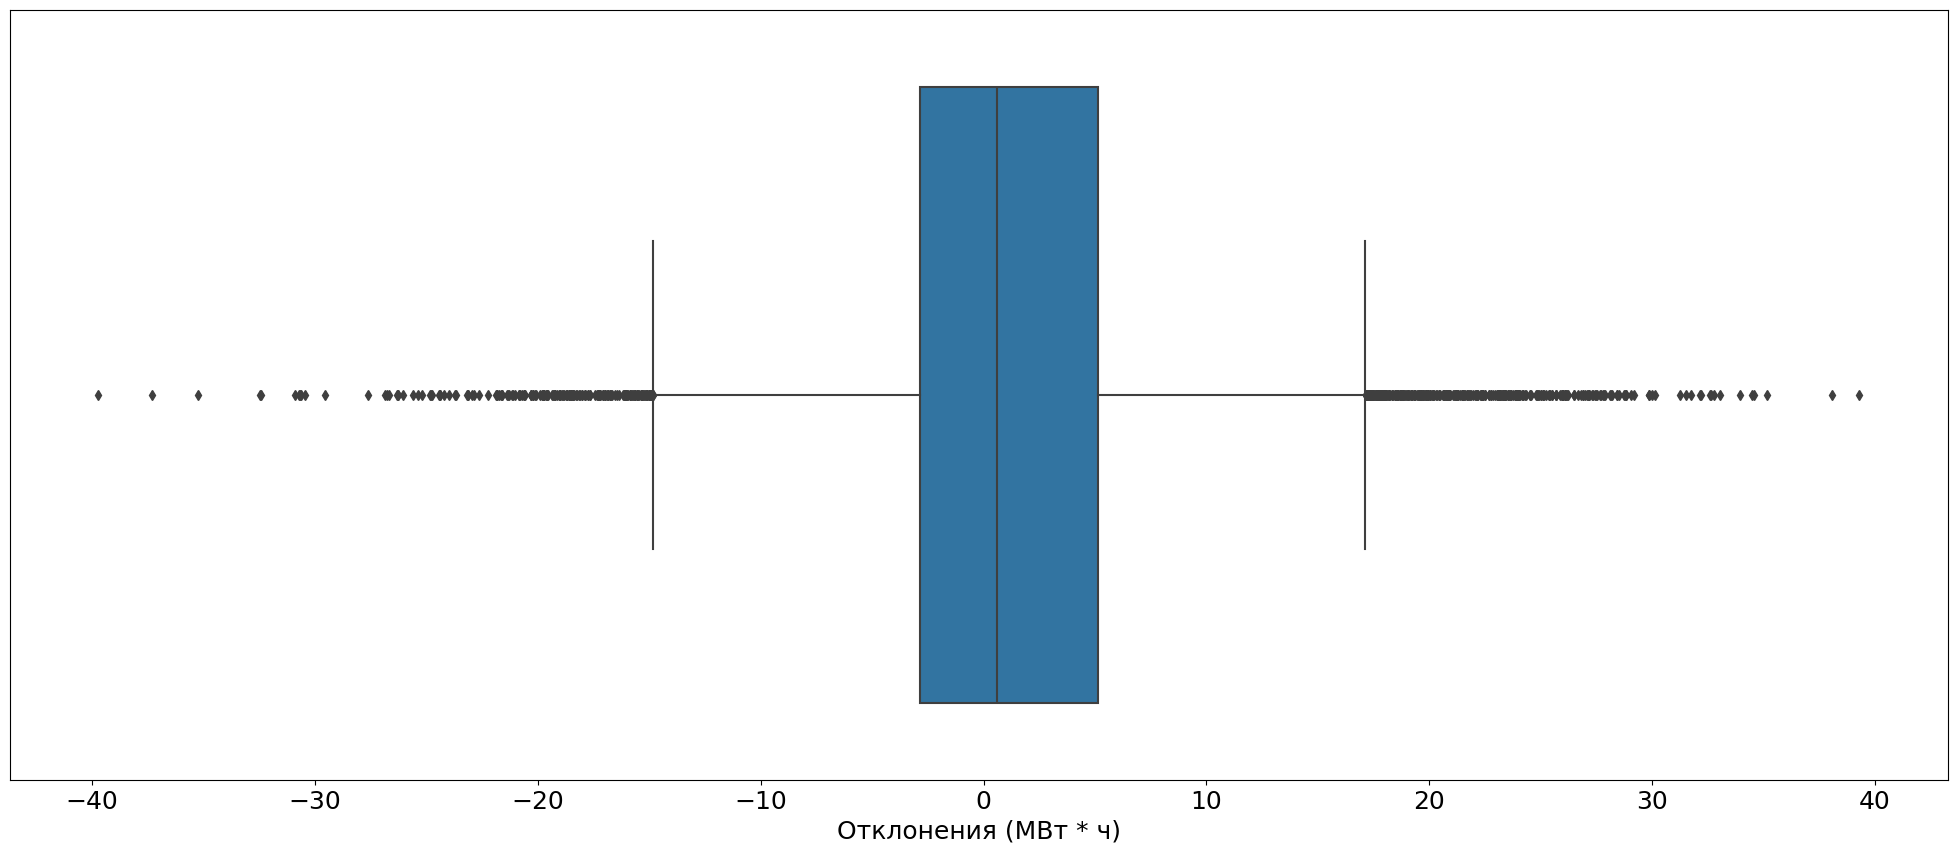

In [135]:
plt.figure(figsize=(25, 10))
ax = sns.boxplot(pd.DataFrame(errors), orient="h")
ax.yaxis.set_major_locator(NullLocator())
plt.xticks(np.arange(-40, 50, 10), fontsize=18)
plt.xlabel("Отклонения (МВт * ч)", fontsize=18)
plt.show()

In [136]:
IQR: float = errors.quantile(q=0.75) - errors.quantile(q=0.25)
right_hence: float = errors.quantile(q=0.75) + IQR * 1.5
left_hence: float = errors.quantile(q=0.25) - IQR * 1.5
print(f"Межквартильный размах равен {IQR:.3f} (МВт * ч)")
print(f"Нижний порог равен {left_hence:.3f} (МВт * ч)")
print(f"Верхний порог равен {right_hence:.3f} (МВт * ч)")

Межквартильный размах равен 7.986 (МВт * ч)
Нижний порог равен -14.815 (МВт * ч)
Верхний порог равен 17.131 (МВт * ч)


In [137]:
extra_outliers: pd.Series = errors[(errors > right_hence) | (errors < left_hence)]
extra_outliers

Дата и время
2022-08-12 16:00:00   -24.419
2022-08-12 17:00:00   -17.866
2022-08-13 16:00:00    27.537
2022-08-13 17:00:00    25.104
2022-08-15 11:00:00    18.206
                        ...  
2023-05-27 18:00:00    20.846
2023-05-27 19:00:00    23.535
2023-05-27 20:00:00    22.144
2023-05-27 23:00:00    17.431
2023-06-27 14:00:00   -14.855
Name: Электропотребление, Length: 527, dtype: float64

In [138]:
round(len(extra_outliers) / len(y_pred_test) * 100, 3)

6.719

<h2>6.719 % тестовых прогнозов превышают норму.</h2>

In [139]:
max_positive_error: float = (y_test - y_pred_test).max()
max_negative_error: float = (y_test - y_pred_test).min()
print(f"Максимальная положительная ошибка {max_positive_error:.3f} (МВт * ч)")
print(f"Максимальная отрицательная ошибка {max_negative_error:.3f} (МВт * ч)")

Максимальная положительная ошибка 39.296 (МВт * ч)
Максимальная отрицательная ошибка -39.733 (МВт * ч)


<center><h1><b>Выгрузка итоговой модели</b></h1></center>

In [27]:
final_lgbm = LGBMRegressor(
    n_estimators=57,
    max_depth=10,
    bagging_freq=1,
    importance_type="gain",
    random_state=1,
    n_jobs=-1,
    force_row_wise=True,
    verbose=-1
)
final_lgbm.fit(X, y)

LGBMRegressor(bagging_freq=1, force_row_wise=True, importance_type='gain',
              max_depth=10, n_estimators=57, n_jobs=-1, random_state=1,
              verbose=-1)

In [28]:
joblib.dump(final_lgbm, "regression.model")

['regression.model']